In [1]:
import pandas as pd
import  sys
import matplotlib.pyplot as plt
sys.path.insert(1, '../MLA')
import imp
import numpy as np
import xgboost_wrapper as xw
import regression_wrappers as rw
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [3]:
# A = pd.read_csv("CHESS%20COVID19%20CaseReport%2020200401.csv")
A = pd.read_csv("CHESS COVID19 CaseReport 20200628.csv")
#

In [4]:
A_ = pd.read_csv("CHESS COVID19 CaseReport 20200628.csv")
idx = A_['asymptomatictesting']=='Yes'
A_ = A_.loc[idx,][['infectionswabdate', 'hospitaladmissiondate']]
lag = pd.to_datetime(A_['infectionswabdate']).dt.round('D') - pd.to_datetime(A_['hospitaladmissiondate']).dt.round('D')

In [5]:
# plt.hist(lag.dt.days, bins=50);
print('swab at or after admission:')
print(np.sum(lag.dt.days >= 0))
print('swab before admission:')
print(np.sum(lag.dt.days < 0))

swab at or after admission:
379
swab before admission:
29


In [6]:
# A = pd.read_csv("CHESS COVID19 CaseReport 20200601.csv")
def to_eliminate(x):
    if str(x.finaloutcomedate) == 'nan':
        if str(x.finaloutcome) == 'nan':
            return True
        elif 'still on unit' in str(x.finaloutcome):
            return True
        else:
            return False
    elif str(x.finaloutcomedate) == '1900-01-01':
        return True
    else:
        return False

to_elimi = A[['finaloutcomedate','dateadmittedicu','finaloutcome']].apply(to_eliminate, axis=1)

In [7]:
to_elimi.sum()

4213

In [8]:
A['dateupdated'] = pd.to_datetime(A['dateupdated']).dt.round('D')
A[['hospitaladmissiondate','finaloutcomedate','dateadmittedicu','finaloutcome','dateupdated']].head()

,hospitaladmissiondate,finaloutcomedate,dateadmittedicu,finaloutcome,dateupdated
0,2020-03-12,NaN,2020-03-12,Death,2020-04-21
1,2020-03-10,NaN,NaN,NaN,2020-03-16
2,2020-03-09,2020-03-23,2020-03-14,Death,2020-06-12
3,2020-03-10,2020-03-22,2020-03-12,Death,2020-06-12
4,NaN,NaN,NaN,NaN,NaT


In [9]:
A = A[~to_elimi]

In [10]:
pd.to_datetime(A['hospitaladmissiondate']).min(), pd.to_datetime( A['dateleavingicu']).max() 

(Timestamp('2019-08-20 00:00:00'), Timestamp('2020-06-26 00:00:00'))

In [11]:
A = A.loc[~A.caseid.duplicated()]

In [12]:
A = A.rename(columns={'immunosuppressiontreatmentcondit': 'immunosuppressiontreatmentcondition'})
A = A.rename(columns={'immunosuppressiondiseaseconditio': 'immunosuppressiondiseasecondition'})

In [13]:
for feature in ['isviralpneumoniacomplication',
       'isardscomplication', 'isunknowncomplication',
       'isothercoinfectionscomplication', 'isothercomplication',
       'issecondarybacterialpneumoniacom',
       'chronicrespiratory', 'asthmarequiring',
       'chronicheart',
       'chronicrenal', 'asymptomatictesting',
       'chronicliver',
       'chronicneurological', 
       'immunosuppressiontreatment', 'immunosuppressiondisease', 'obesityclinical', 'pregnancy',
       'other',
       'hypertension', 'seriousmentalillness']:
    A[feature] = A[feature].apply(lambda x: 1 if 'Yes' in str(x) else 0)

In [14]:
A = A.rename(columns={'other': 'other_comorbidity'})

In [15]:
A['age10year'] = A['ageyear'].apply(lambda x: x/10)

In [16]:
A['sex_is_M'] = A['sex'].apply(lambda x: 1 if 'Male' in x else 0)

In [17]:
A['sex_is_unkn'] = A['sex'].apply(lambda x: 1 if 'Unknown' in x else 0)

In [18]:
A = A.drop(columns = ['ageyear', 'sex'])

In [19]:
A['ethnicity'] = A['ethnicity'].apply(lambda x: 'Eth. NA' if pd.isna(x) else x)

In [20]:
A['ethnicity'] = A['ethnicity'].apply(lambda x: x.strip(' '))

In [21]:
def stratify(df, feature):
    keys = [str(s) for s in df[feature].unique()]
    keys = list(set(keys))
    df = df.copy()
    for key in keys:
        df[key.strip(' ')] = df[feature].apply(lambda x, key: 1 if str(x)==key else 0, args=(key, ))
    return df.drop(columns=feature)

In [22]:
A['ethnicity'].value_counts()

White British                8628
Eth. NA                      1895
Unknown                      1496
Other White                   369
Other Asian                   341
other                         340
Indian                        333
Pakistani                     264
Black African                 189
Black Caribbean               139
Other Black                    85
White Irish                    60
Other mixed                    53
Bangladeshi                    52
White and Black Caribbean      43
Chinese                        41
White and Black African        29
White and Asian                23
Name: ethnicity, dtype: int64

In [23]:
A['ethnicity'].value_counts().sum(), A.shape

(14380, (14380, 101))

In [24]:
A = stratify(A, 'ethnicity')

In [25]:
A = A.rename(columns={'Unknown':'Eth. unknown',
                      'other':'Other ethn.',
                      'White British': 'White British',
'Other White': 'Other white',
'Other Asian': 'Other Asian',
'Black African':'Black African',
'Black Caribbean':'Black Caribbean',
'Other Black': 'Other black',
'White Irish': 'White Irish',
'White and Black Caribbean':'White and black Caribbean',
'Other mixed':'Other mixed',
'White and Black African':'White and black African',
'White and Asian':'White and Asian'})

In [26]:
def diabetes_type(x):
    if x.isdiabetes == 'Yes':
        if x.diabetestype == 'Type I':
            return 'T1 diabetes'
        else:
            return 'T2 diabetes'
    else:
        return np.nan

In [27]:
A['diabetes'] = A[['isdiabetes', 'diabetestype']].apply(diabetes_type, axis=1)

In [28]:
A = stratify(A, 'diabetes')

In [29]:
# drop nan column created from stratification of diabetes categorical
A = A.drop(columns=['isdiabetes','nan', 'diabetestype'])

In [30]:
A = A.drop(columns=['organismname'])

In [31]:
to_drop = ['trustcode', 'trustname', 'dateupdated', 'weekno',
       'weekofadmission', 'yearofadmission', 'agemonth', 'postcode',
       'estimateddateonset', 'infectionswabdate', 'labtestdate',
       'typeofspecimen', 'otherspecimentype', 'covid19',
       'influenzaah1n1pdm2009', 'influenzaah3n2', 'influenzab',
       'influenzaanonsubtyped', 'influenzaaunsubtypable', 'rsv',
       'otherresult', 'otherdetails', 'admissionflu', 'admissionrsv',
       'admissioncovid19', 'admittedfrom', 'otherhospital', 'hospitaladmissionhours',
       'hospitaladmissionminutes', 'hospitaladmissionadmittedfrom',
       'wasthepatientadmittedtoicu',
       'hoursadmittedicu', 'minutesadmittedicu', 'sbother', 'sbdate', 'respiratorysupportnone',
       'oxygenviacannulaeormask', 'highflownasaloxygen',
       'noninvasivemechanicalventilation',
       'invasivemechanicalventilation', 'respiratorysupportecmo',
       'mechanicalinvasiveventilationdur', 'anticovid19treatment',
       'chronicrespiratorycondition', 'respiratorysupportunknown',
       'asthmarequiringcondition', 'seriousmentalillnesscondition',
       'chronicheartcondition', 'hypertensioncondition',
       'immunosuppressiontreatmentcondition',
       'immunosuppressiondiseasecondition',
       'obesitybmi', 'gestationweek', 'travelin14days',
       'travelin14dayscondition', 'prematurity', 'chroniclivercondition',
       'worksashealthcareworker', 'contactwithconfirmedcovid19case',
       'contactwithconfirmedcovid19casec', 'othercondition',
       'transferdestination', 'chronicneurologicalcondition',
       'outcomeother', 'causeofdeath', 'chronicrenalcondition', 'othercomplication']

In [32]:
A = A.drop(columns=to_drop)

In [33]:
A['caseid'] = A['caseid'].astype(int)

In [34]:
A = A.set_index('caseid')

In [35]:
A = A.loc[A.age10year > 0]

In [36]:
A['is_ICU'] = ~A['dateadmittedicu'].isna()

In [37]:
A['is_death'] = A['finaloutcome'] == 'Death'

In [38]:
print(A['is_ICU'].sum())

5758


In [39]:
print(A['is_death'].sum())

5007


In [40]:
print((A['is_death'] & A['is_ICU']).sum())

2275


In [41]:
A.to_csv('CHESS_comorb_only_with_outcome.csv')

In [42]:
A = pd.read_csv('CHESS_comorb_only_with_outcome.csv')
A = A.set_index('caseid')

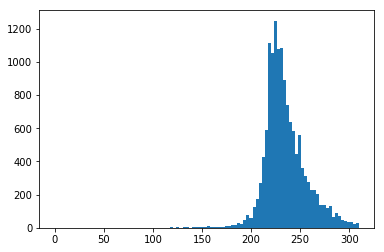

In [43]:
min_date = pd.to_datetime(A.hospitaladmissiondate).min()
A['day_from_beginning1'] = (pd.to_datetime(A.hospitaladmissiondate) - min_date).dt.days
plt.hist(A['day_from_beginning1'], bins=100);

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
trasformed=sc.fit_transform(A['day_from_beginning1'].values.reshape(-1,1))
A['days from beginning'] = trasformed.flatten() #+ np.mean(trasformed.flatten())
A = A.drop(columns=['day_from_beginning1'])

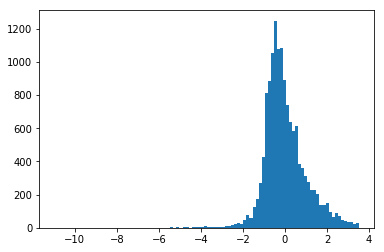

In [45]:
plt.hist(A['days from beginning'], bins=100);

In [46]:
A['clinical experience'] = A['days from beginning'].rank()
A['clinical experience'] = A['clinical experience'] / A['clinical experience'].max()

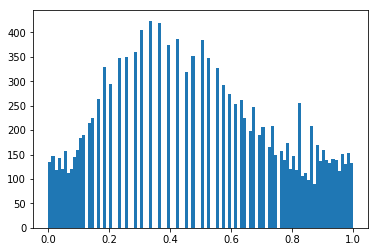

In [47]:
plt.hist(A['clinical experience'], bins=100);

In [48]:
def int_to_date(x, min_date):
    timestamp = pd.to_timedelta(x, unit='D') + min_date
    return '-'.join([str(timestamp.day), str(timestamp.month), str(timestamp.year)[-2:]])
    # pd.to_timedelta(A['day_from_beginning1'], unit='D') + min_date).head()

In [49]:
A['is_death'].sum(), A['is_ICU'].sum()

(5007, 5758)

count    13954.000000
mean        67.591228
std         17.276070
min          1.000000
25%         56.000000
50%         70.000000
75%         81.000000
max        105.000000
Name: age10year, dtype: float64

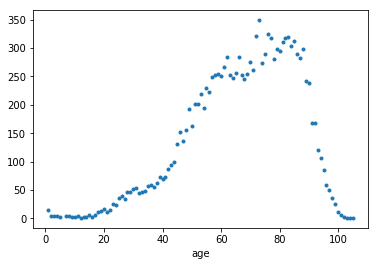

In [50]:
a = (10 * A['age10year']).value_counts().reset_index().sort_values(by='index').values
plt.plot(a[:,0], a[:,1],'.')
plt.xlabel('age');
(10 * A['age10year']).describe()

In [51]:
dizionario = {'chronicrespiratory':'Chronic respiratory disease',
              'asthmarequiring':'Asthma',
              'chronicheart':'Chronic heart disease',
              'chronicrenal':'Chronic renal disease',
              'chronicneurological':'Chronic neurological cond.',
              'immunosuppressiontreatment':'Immunosuppression treatment',
              'immunosuppressiondisease':'Immunosuppression disease',
              'obesityclinical':'Obesity (clinical)',
              'other_comorbidity':'Other comorbidity',
              'age10year': 'Age (x10 years)',
              'sex_is_M':'Sex male',
              'sex_is_unkn':'Sex unknown',
              'asymptomatictesting':'Asymptomatic testing',
              'seriousmentalillness':'Serious mental illness',
              'chronicliver':'Chronic liver',
              'chronicliver_fatty':'Chronic fat liver',
              'chronicliver_alcohol':'Chronic alcohol. liver',
              'chronicliver_other': 'Chronic liver disease',
              'hypertension': 'Hypertension',
              'pregnancy': 'Pregnancy'}

In [52]:
A = A.rename(columns=dizionario)

In [53]:
A['Sex unknown'].sum() / A.shape[0] * 100

0.17916009746309303

In [54]:
A['Sex male'].sum() / A.shape[0] * 100

59.25182743299412

In [55]:
A[A['is_ICU']]['is_death'].sum()

2275

In [56]:
A.shape

(13954, 53)

In [57]:
A = A.rename(columns={'days from beginning': 'Admission day'})

# Clustermap

In [58]:
!mkdir results_10Nov

mkdir: cannot create directory ‘results_10Nov’: File exists


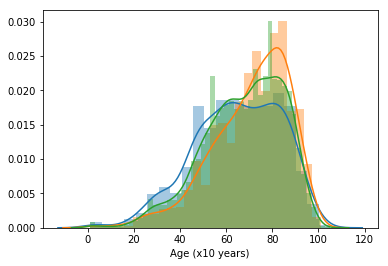

In [59]:
import seaborn as sns
sns.distplot(A[A['Eth. unknown'].astype('bool')]['Age (x10 years)'] * 10)
sns.distplot(A[A['Eth. NA'].astype('bool')]['Age (x10 years)']* 10)
sns.distplot(A['Age (x10 years)']* 10)

number of people who didn't report any ethnicity
0


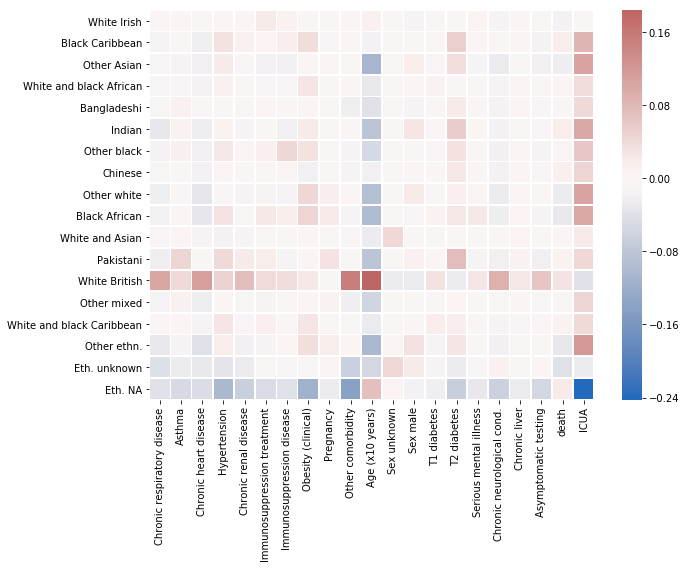

In [60]:
import seaborn as sns
C =  A.drop(columns=['dateadmittedicu', 'hospitaladmissiondate', 'finaloutcome', 'finaloutcomedate', 'dateleavingicu',
       'isviralpneumoniacomplication', 'issecondarybacterialpneumoniacom',
       'isardscomplication', 'isunknowncomplication',
       'isothercoinfectionscomplication', 'isothercomplication'])

# Draw the full plt
ethnicity = ['White Irish', 'Black Caribbean', 'Other Asian', 'White and black African',
             'Bangladeshi', 'Indian',
             'Other black',  'Chinese', 'Other white', 'Black African', 'White and Asian',
             'Pakistani', 'White British', 'Other mixed', 'White and black Caribbean', 'Other ethn.',
             'Eth. unknown', 'Eth. NA']

print("number of people who didn't report any ethnicity")
print(C[ethnicity].apply(lambda x: ~x.any(), axis=1).sum())
# C['NA'] = C[ethnicity].apply(lambda x: ~x.any(), axis=1)
comorbidities = ['chronicrespiratory', 'asthmarequiring', 'chronicheart', 'hypertension',
       'chronicrenal', 'immunosuppressiontreatment',
       'immunosuppressiondisease', 'obesityclinical', 'pregnancy',
       'other_comorbidity', 'age10year', 'sex_is_unkn', 'sex_is_M',
       'T1 diabetes', 'T2 diabetes', 'seriousmentalillness',
       'chronicneurological', 'chronicliver', 'asymptomatictesting']

comorbidities =[dizionario.get(x) if x in dizionario  else x for x in comorbidities ]

Ccorr = C.corr();
Ccorr1 = Ccorr[comorbidities +['is_death', 'is_ICU']].loc[ethnicity,:]
Ccorr1 = Ccorr1.rename(columns={'is_death':'death', 'is_ICU':'ICUA'})
fig,ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(Ccorr1, center=0, cmap="vlag", ax=ax,
#                row_colors=network_colors,
#                col_colors=network_colors,
               linewidths=.75)
#                figsize=(13, 13))

fig = plt.gcf()
plt.tight_layout()
plt.savefig('results_10Nov/correlation1_new.png')

In [61]:
dizionarioR = {'Age..x10.years.':'Age (x10 years)',
 'Asthma':'Asthma',
 'Black.African':'Black African',
 'Black.Caribbean':'Black Caribbean',
 'Chronic.heart.disease':'Chronic heart disease',
 'Chronic.liver':'Chronic liver',
 'Chronic.neurological.cond.':'Chronic neurological cond.',
 'Chronic.renal.disease':'Chronic renal disease',
 'Chronic.respiratory.disease':'Chronic respiratory disease',
 'Immunosuppression.disease':'Immunosuppression disease',
 'Immunosuppression.treatment':'Immunosuppression treatment',
 'Obesity..clinical.':'Obesity (clinical)',
 'Other.Asian':'Other Asian',
 'Other.black':'Other black',
 'Other.comorbidity':'Other comorbidity',
 'Other.ethn.':'Other ethn.',
 'Other.mixed':'Other mixed',
 'Other.white':'Other white',
 'Serious.mental.illness':'Serious mental illness',
 'Sex.male':'Sex male',
 'Sex.unknown':'Sex unknown',
 'T1.diabetes':'T1 diabetes',
 'T2.diabetes':'T2 diabetes',
 'White.and.Asian':'White and Asian',
 'White.and.black.African':'White and black African',
 'White.and.black.Caribbean':'White and black Caribbean',
 'White.British':'White British',
 'White.Irish':'White Irish',
 'Asymptomatic.testing':'Asymptomatic testing',
 'Admission.day':'Admission day',
 'Clinical.experience':'Clinical experience',
 'Eth..NA':'Eth. NA',
 'Eth..unknown':'Eth. unknown'               
}

# Logistic 1

In [242]:
ethnicity = ['Black Caribbean', 'Other Asian', 'White and black African', 'Bangladeshi', 'Indian',
             'Other black',  'Chinese', 'Other white', 'Black African', 'White and Asian', 'Pakistani',
             'Eth. unknown', 'Eth. NA', 'Other mixed', 'White and black Caribbean', 'White British', 'White Irish', 'Other ethn.']

In [243]:
B =  A.drop(columns=['dateadmittedicu', 'hospitaladmissiondate', 'finaloutcome', 'finaloutcomedate', 'dateleavingicu',
       'isviralpneumoniacomplication', 'issecondarybacterialpneumoniacom',
       'isardscomplication', 'isunknowncomplication', 'patientstillonicu', 
       'isothercoinfectionscomplication', 'isothercomplication']).drop(columns=['clinical experience'])

In [244]:
percentages_eth = pd.DataFrame((B[ethnicity].sum() / B.shape[0]).sort_values(ascending=False))
percentages_com = pd.DataFrame((B[comorbidities].sum() / B.shape[0]).sort_values(ascending=False))

In [245]:
percentages_eth

,0
White British,0.598036
Eth. NA,0.133510
Eth. unknown,0.101620
Other white,0.026086
Other Asian,0.024222
Other ethn.,0.023792
Indian,0.023649
Pakistani,0.018633
Black African,0.013330
Black Caribbean,0.009890


In [246]:
percentages_com

,0
Age (x10 years),6.759123
Sex male,0.592518
Other comorbidity,0.314748
Hypertension,0.269528
Chronic heart disease,0.161029
T2 diabetes,0.159166
Chronic respiratory disease,0.109073
Obesity (clinical),0.106206
Chronic neurological cond.,0.087287
Chronic renal disease,0.083847


In [247]:
percentages_eth.to_excel('results_10Nov/frequencies_et.xls')
percentages_com.to_excel('results_10Nov/frequencies_com.xls')

In [68]:
targets = ['is_death', 'is_ICU']

In [69]:
B=B.drop(columns='White British')

## Death outcome

In [70]:
target = 'is_death'
predictors = [x for x in B.columns if x not in targets]
X_train, X_test, y_train, y_test = train_test_split(B[predictors], B[target], test_size=0.1, random_state=42)

In [71]:
X_train.to_csv('results_10Nov/X_train_death.csv') 
pd.DataFrame(y_train).to_csv('results_10Nov/y_train_death.csv')
X_test.to_csv('results_10Nov/X_test_death.csv')

In [72]:
!pwd

/run/media/root/raiddisk2/massimocavallaro/AMR/COVID


In [73]:
!/usr/bin/Rscript logisticregression.R results_10Nov/X_train_death.csv results_10Nov/y_train_death.csv results_10Nov/X_test_death.csv results_10Nov/logistic_summary_death.csv results_10Nov/logistic_prediction_death.csv

Waiting for profiling to be done...
Waiting for profiling to be done...
alias:Model :
is_death ~ Asymptomatic.testing + Chronic.respiratory.disease + 
    Asthma + Chronic.heart.disease + Hypertension + Chronic.renal.disease + 
    Chronic.liver + Chronic.neurological.cond. + Immunosuppression.treatment + 
    Immunosuppression.disease + Obesity..clinical. + Pregnancy + 
    Serious.mental.illness + Other.comorbidity + Age..x10.years. + 
    Sex.male + Sex.unknown + White.and.black.Caribbean + Other.black + 
    Pakistani + Indian + White.and.black.African + Bangladeshi + 
    Eth..unknown + Other.white + Black.African + Other.mixed + 
    White.and.Asian + Other.ethn. + Chinese + Black.Caribbean + 
    Eth..NA + White.Irish + Other.Asian + T2.diabetes + T1.diabetes + 
    Admission.day



In [74]:
Vif_death = pd.read_csv("tmp.csv")
Vif_death.sort_values(by='vif.logitMod.', ascending=False).head()

,vif.logitMod.
Age..x10.years.,1.292251
Hypertension,1.262742
Chronic.heart.disease,1.252156
T2.diabetes,1.186751
Other.comorbidity,1.175511


In [75]:
# Vif_death.sort_values(by='vif.logitMod.', ascending=False).rename(index=dizionarioR).to_excel('results_10Nov/vif_GLM_death_1.xls')

In [76]:
logistic_summary = pd.read_csv("results_10Nov/logistic_summary_death.csv")
logistic_prediction = pd.read_csv("results_10Nov/logistic_prediction_death.csv")

[0.655 0.681 0.708]


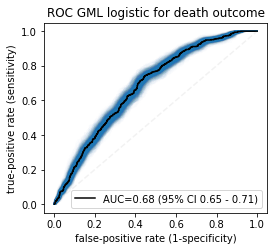

In [77]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
xw.buildROC(y_test, logistic_prediction, ax, color=None, label=None, CI=True)
ax.set_title('ROC GML logistic for death outcome');
# fig.savefig('results_10Nov/ROC_GML_death_1.png')

[0.653 0.681 0.709]


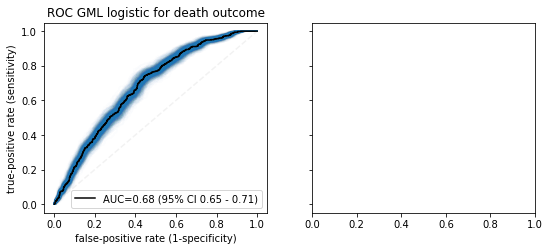

In [78]:
fig_, ax_ = plt.subplots(1, 2, figsize=(4 * 2.2, 3.5), sharey=True)
xw.buildROC(y_test, logistic_prediction, ax_[0], color=None, label=None, CI=True)
ax_[0].set_title('ROC GML logistic for death outcome');
# fig.savefig('results_10Nov/ROC_GML_death_1.png')

In [79]:
logistic_summary['OR'] = np.exp(logistic_summary['Estimate'])
# Taylor series-based delta method
logistic_summary['OR_sd'] = logistic_summary[['Std. Error', 'OR']].apply(lambda x: np.sqrt(x.OR**2) * x['Std. Error'], axis=1)

In [80]:
def is_not_ethn(x):
    if x in ['Bangladeshi', 'Black.African', 'Black.Caribbean', 'Chinese',  'Other.ethn.',  'Indian',  'Other.Asian',
             'Other.black', 'Other.mixed', 
             'Other.white', 'Pakistani', 'White.and.Asian', 'White.and.black.African',
             'White.and.black.Caribbean', 'Eth..unknown', 'Eth..NA','White.Irish']:
        return 1
    elif ('Sex' in x) or ('Age' in x) or ('Admis' in x) or ('Pregnan' in x) or ("Asympt" in x) or ("Immunosuppression.treatment" in x):
        return 0
    else:
        return 2

In [81]:
logistic_summary['order'] = logistic_summary['Row.names'].apply(is_not_ethn)

In [82]:
logistic_summary = logistic_summary.sort_values(by=['order','Estimate'], ascending=False).drop(columns=['order'])

In [83]:
logistic_summary['Row.names'] = logistic_summary['Row.names'].apply(lambda x: dizionarioR.get(x) if x in dizionarioR else x)

In [84]:
logistic_summary

,Row.names,2.5 %.x,97.5 %.x,Estimate,Std. Error,z value,Pr(>|z|),OR.x,2.5 %.y,97.5 %.y,p.x,OR.y,15.9 %,84.1 %,p.y,OR,OR_sd
18,Immunosuppression disease,0.093422,0.568209,0.330815,0.121121,2.731272,6.309046e-03,1.392103,1.096929,1.764122,6.309046e-03,1.392103,1.233066,1.571056,6.309046e-03,1.392103,0.168613
34,T2 diabetes,0.155458,0.380135,0.267796,0.057317,4.672222,2.979582e-06,1.307081,1.168038,1.462326,2.979582e-06,1.307081,1.234243,1.384132,2.979582e-06,1.307081,0.074918
33,T1 diabetes,-0.163411,0.573789,0.205189,0.188065,1.091055,2.752488e-01,1.227757,0.845259,1.769186,2.752488e-01,1.227757,1.016161,1.480353,2.752488e-01,1.227757,0.230898
11,Chronic liver,-0.108958,0.497739,0.194391,0.154773,1.255975,2.091251e-01,1.214570,0.893629,1.640559,2.091251e-01,1.214570,1.039550,1.416773,2.091251e-01,1.214570,0.187982
14,Chronic respiratory disease,0.045858,0.298083,0.171970,0.064344,2.672658,7.525297e-03,1.187643,1.046686,1.347020,7.525297e-03,1.187643,1.113581,1.266492,7.525297e-03,1.187643,0.076418
21,Obesity (clinical),0.014250,0.287636,0.150943,0.069742,2.164294,3.044182e-02,1.162931,1.013816,1.332642,3.044182e-02,1.162931,1.084457,1.246758,3.044182e-02,1.162931,0.081106
30,Serious mental illness,-0.442417,0.610097,0.083840,0.268503,0.312249,7.548512e-01,1.087455,0.632120,1.819131,7.548512e-01,1.087455,0.828171,1.417611,7.548512e-01,1.087455,0.291985
13,Chronic renal disease,-0.064676,0.220477,0.077900,0.072744,1.070878,2.842244e-01,1.081015,0.937192,1.246500,2.842244e-01,1.081015,1.005136,1.162523,2.842244e-01,1.081015,0.078638
12,Chronic neurological cond.,-0.076819,0.201031,0.062106,0.070881,0.876194,3.809248e-01,1.064075,0.925759,1.222339,3.809248e-01,1.064075,0.991196,1.142138,3.809248e-01,1.064075,0.075423
10,Chronic heart disease,-0.096673,0.130488,0.016907,0.057950,0.291758,7.704720e-01,1.017051,0.907714,1.139237,7.704720e-01,1.017051,0.959762,1.077681,7.704720e-01,1.017051,0.058938


In [85]:
def pvaluesymbol(P):
    if P > 0.05:
        return ''
    elif (P <= 0.05) & (P > 0.01):
        return '*'
    elif (P <= 0.01) & (P > 0.001):
        return '**'
    elif (P <= 0.001) & (P > 0.0001):
        return '***'
    elif P <= 0.0001:
        return '****'

In [86]:
logistic_summary['pvaluesymbol'] = logistic_summary['Pr(>|z|)'].apply(pvaluesymbol)

In [87]:
logistic_summary.to_excel('results_10Nov/coefficients_GLM_death_1.xls')

In [88]:
def plot_coeff(summary, ax, title=None, xtext=None):
    summary = summary.sort_values(by='Estimate', ascending=True)
    summary.plot.barh(x='Row.names', y='Estimate',  
             ax=ax, color='none',
             xerr='Std. Error',
             legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.scatter(y=pd.np.arange(summary.shape[0]), 
               marker='s', s=120, 
               x=summary['Estimate'], color='black')
    ax.axvline(x=0, linestyle='--', color='grey', linewidth=1)
    if xtext is None:
        xtext = ax.get_xlim()[1]
    for i, p in enumerate(summary.pvaluesymbol.values):
#         try:
            ax.text(xtext, i, p)
#             print(p)
#         except:
#             pass


def plot_OR(summary, ax, title=None, xtext=None):
#     summary['order'] = summary['Row.names'].apply(is_not_ethn)
#     summary = summary.sort_values(by=['order', 'Estimate'], ascending=True)
    summary = summary.loc[::-1,]
    xerr = summary.apply(lambda x: (x['OR']- x["2.5 %.y"], x["97.5 %.y"] -x['OR']), result_type='expand', axis=1).values.transpose()
#     print(xerr.head())
#     print(xerr.tail())
    summary.plot.barh(x='Row.names', y='OR',  
             ax=ax, color='none',
             xerr=xerr,
             legend=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.scatter(y=pd.np.arange(summary.shape[0]), 
               marker='s', s=120, 
               x=summary['OR'], color='black')
    ax.axvline(x=1, linestyle='--', color='grey', linewidth=1)
    if xtext is None:
        xtext = ax.get_xlim()[1]
    for i, p in enumerate(summary.pvaluesymbol.values):
        try:
            float(p)
            bo = False
        except:
            bo = True
        if bo:
            ax.text(xtext, i, p)

In [89]:
logistic_summary.to_excel('results_10Nov/coefficients_GLM_death_1_britbaseline.xls')
logistic_summary = pd.read_excel('results_10Nov/coefficients_GLM_death_1_britbaseline.xls')

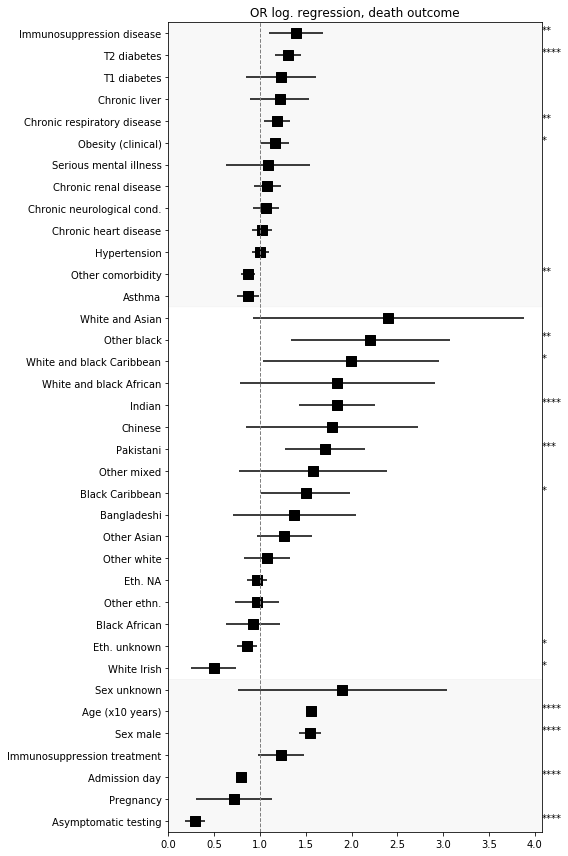

In [90]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_OR(logistic_summary.drop(index=1), ax, title='OR log. regression, death outcome')
ax.autoscale(enable=False)
ax.fill_between([-10,100],[-1,-1], [6.5, 6.5], color='grey', alpha=0.05, zorder=-100)
ax.fill_between([-10,100],[23.5,23.5], [100,105], color='grey', alpha=0.05, zorder=-100)
fig.tight_layout()
fig.savefig('results_10Nov/OR_GML_death_1.png')

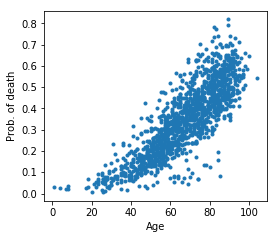

In [91]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
plt.plot(X_test['Age (x10 years)'] * 10, logistic_prediction, '.')
# ax.set_title('ROC XGBoost for ICU outcome');
ax.set_xlabel('Age');
ax.set_ylabel('Prob. of death');

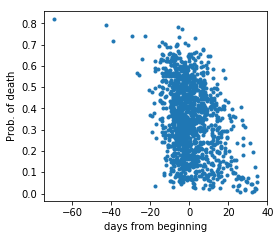

In [92]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
plt.plot(X_test['Admission day'] * 10, logistic_prediction, '.')
# ax.set_title('ROC XGBoost for ICU outcome');
ax.set_xlabel('days from beginning');
ax.set_ylabel('Prob. of death');


## ICU outcome

In [93]:
target = 'is_ICU'
predictors = [x for x in B.columns if x not in targets]
X_train, X_test, y_train, y_test = train_test_split(B[predictors], B[target], test_size=0.1, random_state=42)

In [94]:
X_train.to_csv('results_10Nov/X_train_ICU.csv') 
pd.DataFrame(y_train).to_csv('results_10Nov/y_train_ICU.csv')
X_test.to_csv('results_10Nov/X_test_ICU.csv')

In [95]:
!/usr/bin/Rscript logisticregression.R results_10Nov/X_train_ICU.csv results_10Nov/y_train_ICU.csv results_10Nov/X_test_ICU.csv results_10Nov/logistic_summary_ICU.csv results_10Nov/logistic_prediction_ICU.csv

Waiting for profiling to be done...
Waiting for profiling to be done...
alias:Model :
is_ICU ~ Asymptomatic.testing + Chronic.respiratory.disease + 
    Asthma + Chronic.heart.disease + Hypertension + Chronic.renal.disease + 
    Chronic.liver + Chronic.neurological.cond. + Immunosuppression.treatment + 
    Immunosuppression.disease + Obesity..clinical. + Pregnancy + 
    Serious.mental.illness + Other.comorbidity + Age..x10.years. + 
    Sex.male + Sex.unknown + White.and.black.Caribbean + Other.black + 
    Pakistani + Indian + White.and.black.African + Bangladeshi + 
    Eth..unknown + Other.white + Black.African + Other.mixed + 
    White.and.Asian + Other.ethn. + Chinese + Black.Caribbean + 
    Eth..NA + White.Irish + Other.Asian + T2.diabetes + T1.diabetes + 
    Admission.day



In [96]:
Vif_ICU = pd.read_csv("tmp.csv")
Vif_ICU.sort_values(by='vif.logitMod.', ascending=False)
Vif_ICU.to_excel('results_10Nov/vif_GLM_ICU_1.xls')

In [97]:
Vif = Vif_death.join(Vif_ICU, lsuffix='death', rsuffix='ICU')
Vif.sort_values(by='vif.logitMod.death', ascending=False).rename(index=dizionarioR).to_excel('results_10Nov/vif_GLM_1.xls')

In [98]:
logistic_summary = pd.read_csv("results_10Nov/logistic_summary_ICU.csv")
logistic_prediction = pd.read_csv("results_10Nov/logistic_prediction_ICU.csv")

[0.777 0.8   0.821]


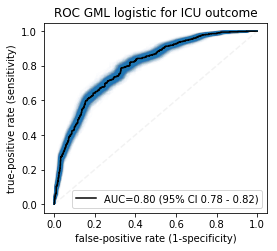

In [99]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
xw.buildROC(y_test, logistic_prediction, ax, color=None, label=None, CI=True);
ax.set_title('ROC GML logistic for ICU outcome');
# fig.savefig('results_10Nov/ROC_GLM_ICU_1.png')

In [100]:
# fig_, ax_ = plt.subplots(1, 2, figsize=(4 * 2.2, 3.5))
xw.buildROC(y_test, logistic_prediction, ax_[1], color=None, label=None, CI=True)
ax_[1].set_title('ROC GML logistic for ICU outcome');
fig_.savefig('results_10Nov/ROC_GML_both_1.png')

[0.777 0.8   0.821]


In [101]:
logistic_summary['OR'] = np.exp(logistic_summary['Estimate'])

# Taylor series-based delta method
logistic_summary['OR_sd'] = logistic_summary[['Std. Error', 'OR']].apply(lambda x: np.sqrt(x.OR**2) * x['Std. Error'], axis=1 )

In [102]:
logistic_summary['pvaluesymbol'] = logistic_summary['Pr(>|z|)'].apply(pvaluesymbol)

In [103]:
logistic_summary['order'] = logistic_summary['Row.names'].apply(is_not_ethn)

In [104]:
logistic_summary = logistic_summary.sort_values(by=['order','Estimate'], ascending=False).drop(columns=['order'])

In [105]:
logistic_summary['Row.names'] = logistic_summary['Row.names'].apply(lambda x: dizionarioR.get(x) if x in dizionarioR else x)

In [106]:
logistic_summary

,Row.names,2.5 %.x,97.5 %.x,Estimate,Std. Error,z value,Pr(>|z|),OR.x,2.5 %.y,97.5 %.y,p.x,OR.y,15.9 %,84.1 %,p.y,OR,OR_sd,pvaluesymbol
21,Obesity (clinical),1.065280,1.365250,1.215265,0.076524,15.880753,8.613806e-57,3.371187,2.904502,3.920855,8.613806e-57,3.371187,3.123685,3.640231,8.613806e-57,3.371187,0.257978,****
1,(Intercept),0.818024,1.223609,1.020816,0.103467,9.866063,5.841217e-23,2.775459,2.266625,3.400554,5.841217e-23,2.775459,2.502873,3.078211,5.841217e-23,2.775459,0.287170,****
30,Serious mental illness,0.403566,1.488264,0.945915,0.276714,3.418387,6.299336e-04,2.575169,1.504375,4.463377,6.299336e-04,2.575169,1.955555,3.402068,6.299336e-04,2.575169,0.712585,***
17,Hypertension,0.349055,0.563348,0.456201,0.054668,8.345001,7.121342e-17,1.578068,1.417860,1.756756,7.121342e-17,1.578068,1.494167,1.666774,7.121342e-17,1.578068,0.086269,****
4,Asthma,0.257954,0.568653,0.413303,0.079261,5.214444,1.843696e-07,1.511804,1.294507,1.766327,1.843696e-07,1.511804,1.396690,1.636585,1.843696e-07,1.511804,0.119827,****
24,Other comorbidity,0.175703,0.370501,0.273102,0.049694,5.495652,3.892695e-08,1.314034,1.192144,1.448563,3.892695e-08,1.314034,1.250358,1.380996,3.892695e-08,1.314034,0.065300,****
11,Chronic liver,-0.184583,0.456421,0.135919,0.163524,0.831184,4.058697e-01,1.145589,0.831353,1.579177,4.058697e-01,1.145589,0.972806,1.349189,4.058697e-01,1.145589,0.187332,
34,T2 diabetes,-0.107550,0.143699,0.018074,0.064096,0.281993,7.779489e-01,1.018239,0.897919,1.154439,7.779489e-01,1.018239,0.955003,1.085602,7.779489e-01,1.018239,0.065265,
14,Chronic respiratory disease,-0.329924,-0.043305,-0.186614,0.073118,-2.552223,1.070379e-02,0.829764,0.718637,0.957222,1.070379e-02,0.829764,0.771175,0.892597,1.070379e-02,0.829764,0.060671,*
18,Immunosuppression disease,-0.455425,0.073421,-0.191002,0.134912,-1.415750,1.568488e-01,0.826131,0.632907,1.074423,1.568488e-01,0.826131,0.721524,0.945008,1.568488e-01,0.826131,0.111455,


In [107]:
logistic_summary.to_excel('results_10Nov/coefficients_GLM_ICU_1_britbaseline.xls')

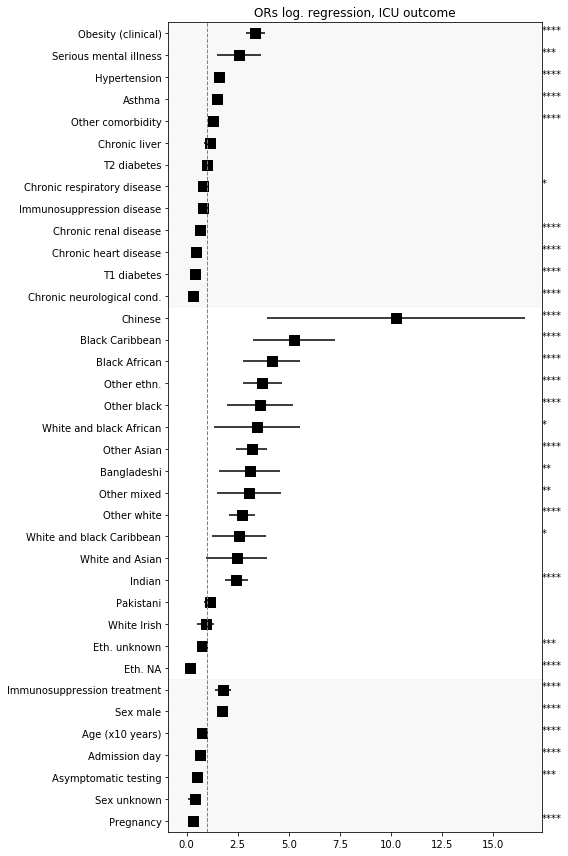

In [108]:
logistic_summary = pd.read_excel('results_10Nov/coefficients_GLM_ICU_1_britbaseline.xls')
fig, ax = plt.subplots(figsize=(8, 12))#
plot_OR(logistic_summary.drop(index=1), ax, title='ORs log. regression, ICU outcome')
ax.autoscale(enable=False)
ax.fill_between([-10,100],[-1,-1], [6.5, 6.5], color='grey', alpha=0.05, zorder=-100)
ax.fill_between([-10,100],[23.5,23.5], [100,105], color='grey', alpha=0.05, zorder=-100)
fig.tight_layout()
fig.savefig('results_10Nov/OR_GML_ICU_1.png')

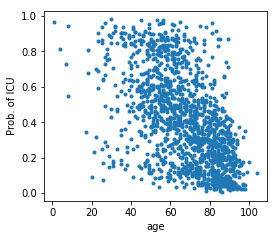

In [109]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
plt.plot(X_test['Age (x10 years)'] * 10, logistic_prediction, '.')
ax.set_xlabel('age');
ax.set_ylabel('Prob. of ICU');

# Cross plots of ORs

In [248]:
logistic_summary_ICU = pd.read_excel('results_10Nov/coefficients_GLM_ICU_1_britbaseline.xls')
logistic_summary_death = pd.read_excel('results_10Nov/coefficients_GLM_death_1_britbaseline.xls')

In [249]:
cross_data = logistic_summary_death.merge(logistic_summary_ICU, on = 'Row.names')

In [250]:
idx = cross_data['Row.names'] == '(Intercept)'

In [251]:
cross_data.drop(cross_data.loc[idx].index, axis='index', inplace=True)

In [252]:
frequencies = pd.concat([percentages_com, percentages_eth]).reset_index()
frequencies = frequencies.append({'index':'clinical experience',
                    0:A['clinical experience'].mean()}, ignore_index=True)
frequencies = frequencies.append({'index':'Admission day',
                    0:A['Admission day'].mean()}, ignore_index=True)

In [253]:
cross_data = cross_data.merge(frequencies, left_on = 'Row.names', right_on='index')
abbreviate = {'Chronic respiratory disease':'Resp. dis.',
              'Asthma (requiring)':'Asthma',
              'Chronic heart disease':'Heart dis.',
              'Chronic renal disease':'Renal dis.',
              'Chronic neurological cond.': 'Neuro. dis.',
              'Immunosuppression treatment': 'Immunos. treat.',
              'Immunosuppression disease': 'Immunos. dis.',
              'Obesity (clinical)': 'Obesity',
              'Other comorbidity': 'Other dis.',
              'Age (x10 years)': 'Age',
              'T2 diabetes':'T2D',
              'Chronic liver':'Liver dis.',
              'T1 diabetes':'T1D',
#               'pregnancy':'pregn.',
#               'sex male':'male',
              'Sex unknown': 'Sex unkn.',
              'Asymptomatic testing': 'Asympt.',
              'Serious mental illness': 'Mental ill.',
              'Chronic liver disease': 'Liver',
              'Eth. unknown':'Eth. unkn.',
              'Eth. NA':'Eth. NA'}

cross_data['Row.names.2'] = cross_data['Row.names'].apply(lambda x: abbreviate.get(x) if x in abbreviate else x)

In [255]:
def is_ethn(x):
    if x in ['Bangladeshi', 'Black African', 'Black Caribbean', 'Chinese',  'Other ethn.',  'Indian',  'Other Asian',
             'Other black', 'Other mixed', 
             'Other white', 'Pakistani', 'White and Asian', 'White and black African',
             'White and black Caribbean', 'Eth. unknown', 'Eth. NA', 'White Irish']:
        return True
    else:
        return False

def is_demog(x):
    if ('Sex' in x) or ('Age' in x) or ('Experie' in x) or ('Admi' in x) or ('Asym' in x) or ('Pregn' in x) or ('tr' in x):
        return True
    else:
        return False

    
idx1 = cross_data['Row.names'].apply(is_ethn)
idx_b = cross_data['Row.names'].apply(is_demog)
idx0 = np.logical_not(idx1) & np.logical_not(idx_b)
cross_data0 = cross_data.loc[idx0,:]
cross_data1 = cross_data.loc[idx1,:]
cross_data2 = cross_data.loc[idx_b,:]

In [256]:
idx = cross_data2['Row.names'].apply(lambda x: ('Age' in x) or ('Admi' in x))
cross_data3 = cross_data2.loc[idx, :]
cross_data4 = cross_data2.loc[~idx, :]

[0.00252257 0.00601978 0.02364913 0.10161961 0.20442884]
[0.001 0.01  0.1   0.25  0.5  ]


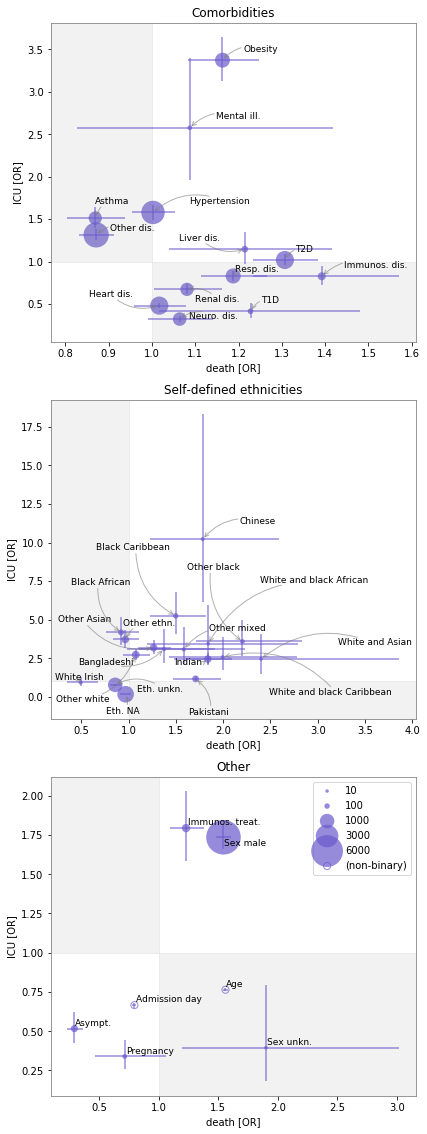

In [257]:
from adjustText import adjust_text
fig, ax = plt.subplots(3, 1 ,figsize=(12 * 1.51 / 3, 3 * 3.5 * 1.51) )
color='tab:grey'
color1='slateblue'
# 15.9%_x 84.1%_x
# 15.9%_y 84.1%_y
alpha1=0.7
alpha=0.6
ax[0].errorbar(cross_data0['OR_x'], cross_data0['OR_y'],
             xerr = [cross_data0['OR_x'] - cross_data0['15.9 %_x'],
                     cross_data0['84.1 %_x'] - cross_data0['OR_x']
                    ],
             yerr = [
                     cross_data0['OR_y'] - cross_data0['15.9 %_y'],
                     cross_data0['84.1 %_y'] - cross_data0['OR_y']
                    ],
               fmt='.', markersize=0, color=color1, alpha=alpha1)



ax[1].errorbar(cross_data1['OR_x'], cross_data1['OR_y'],
             xerr = [cross_data1['OR_x'] - cross_data1['15.9 %_x'],
                     cross_data1['84.1 %_x'] - cross_data1['OR_x']
                    ],
             yerr = [
                     cross_data1['OR_y'] - cross_data1['15.9 %_y'],
                     cross_data1['84.1 %_y'] - cross_data1['OR_y']
                    ],
               fmt='.', markersize=0, color=color1, alpha=alpha1)

ax[2].errorbar(cross_data4['OR_x'], cross_data4['OR_y'],
             xerr = [cross_data4['OR_x'] - cross_data4['15.9 %_x'],
                     cross_data4['84.1 %_x'] - cross_data4['OR_x']
                    ],
             yerr = [
                     cross_data4['OR_y'] - cross_data4['15.9 %_y'],
                     cross_data4['84.1 %_y'] - cross_data4['OR_y']
                    ],
               fmt='.', markersize=0, color=color1, alpha=alpha1)


ax[2].errorbar(cross_data3['OR_x'], cross_data3['OR_y'],
             xerr = [cross_data3['OR_x'] - cross_data3['15.9 %_x'],
                     cross_data3['84.1 %_x'] - cross_data3['OR_x']
                    ],
             yerr = [
                     cross_data3['OR_y'] - cross_data3['15.9 %_y'],
                     cross_data3['84.1 %_y'] - cross_data3['OR_y']
                    ],
               fmt='.', markersize=0, color=color1, alpha=alpha1)


s0=10 + 2000 * cross_data0[0]
s1=10 + 2000 * cross_data1[0]
s4=10 + 2000 * cross_data4[0]

ax[0].scatter(cross_data0['OR_x'], cross_data0['OR_y'], s=s0, color=color1, alpha=alpha1, edgecolors='none')
ax[1].scatter(cross_data1['OR_x'], cross_data1['OR_y'], s=s1, color=color1, alpha=alpha1, edgecolors='none')
ax[2].scatter(cross_data4['OR_x'], cross_data4['OR_y'], s=s4, color=color1, alpha=alpha1, edgecolors='none')
ax[2].scatter(cross_data3['OR_x'], cross_data3['OR_y'], s=50, facecolors='none', alpha=alpha1, edgecolors=color1)

# ax[0].set_xlim([-1, 3])
# ax[0].set_ylim([-1, 4])

ax[0].set_title('Comorbidities')
ax[1].set_title('Self-defined ethnicities')
ax[2].set_title('Other')


for i in [0,1,2]:
#     ax[i].set_xscale('log')
#     ax[i].set_yscale('log')
#     ax[i].axhline(1, linestyle='--',alpha=0.2)
#     ax[i].axvline(1, linestyle='--',alpha=0.2)
    ax[i].autoscale(False)

    ax[i].fill_between([1,100],[1,1],[-100,-100], alpha=0.1, color='gray')
    ax[i].fill_between([-100,1],[100,100],[1, 1], alpha=0.1, color='gray')
    #
    ax[i].set_xlabel('death [OR]')
    ax[i].set_ylabel('ICU [OR]')

    
connectionstyle='arc3,rad=0.3'
shrinkA = 3

def f(y, x, a, b):
    yest = a * x + b
    if y > yest:
        return 'right'
    else:
        return 'left'
    
fontsize=9

plt.sca(ax[0])
a, b = np.polyfit(cross_data0['OR_x'], cross_data0['OR_y'], deg=1)
# ax[0].plot([-10,10], a* np.array([-10,10]) +b)
texts = [plt.text(row['OR_x'], row['OR_y'], row['Row.names.2'], fontsize=fontsize, ha=f(row['OR_y'],row['OR_x'],a,b))
         for i, row in cross_data0.iterrows()]

adjust_text(texts, 
            expand_points=(2.1,2.2),
            expand_objects=(2,2),
            arrowprops=dict(arrowstyle='->', connectionstyle=connectionstyle,  color=color, alpha=alpha)) 

plt.sca(ax[1])
a, b = np.polyfit(cross_data1['OR_x'], cross_data1['OR_y'], deg=1)
texts = [plt.text(row['OR_x'], row['OR_y'], row['Row.names.2'], fontsize=fontsize,  ha=f(row['OR_y'], row['OR_x'],a,b))
         for i, row in cross_data1.iterrows()]
adjust_text(texts,
            expand_points=(2.1,2.2),
            expand_objects=(2,2),
            expand_text=(1,4),
            arrowprops=dict(arrowstyle='->', connectionstyle=connectionstyle, color=color, alpha=alpha))


plt.sca(ax[2])
texts = [plt.text(row['OR_x'], row['OR_y'], row['Row.names.2'], fontsize=fontsize)  for i, row in cross_data2.iterrows()]
adjust_text(texts)
#            arrowprops=dict(arrowstyle='->', connectionstyle=connectionstyle))


Q = np.quantile(cross_data[0], [0.1,0.25,0.5,0.75,0.9])
print(Q)
Q = np.array([0.001, 0.01, 0.1, 0.25, 0.5])
print(Q)
h = [ax[2].scatter(40,40, s=10 + 2000 * q, alpha=alpha1, color=color1, edgecolors='none') for q in Q]
h.append(ax[2].scatter(40,40, s=50, alpha=alpha1, facecolors='none', edgecolors=color1) )
# ax[2].legend(h, ["%.f"%(q) for q in Q * X_train.shape[0]] + ['(non-binary)'])
#ax[2].legend(h, ["%.f"%(q) for q in Q * X_train.shape[0]] + ['(non-binary)'])
ax[2].legend(h, ["%.f"%(q) for q in [10, 100, 1000, 3000, 6000] ] + ['(non-binary)'])

plt.tight_layout()
plt.savefig('results_10Nov/ICU_vs_death_vertical.png', dpi=600)

# XGboost 1

In [119]:
C = A.drop(columns=['dateadmittedicu', 'hospitaladmissiondate', 'finaloutcome', 'finaloutcomedate', 'dateleavingicu',
       'isviralpneumoniacomplication', 'issecondarybacterialpneumoniacom',
       'isardscomplication', 'isunknowncomplication', 'patientstillonicu',
       'isothercoinfectionscomplication', 'isothercomplication', 'White British']).drop(columns=['clinical experience'])


## Death outcome

In [120]:
class binary_Classifier(xw.xgbClassifier):
    def __init__(self, num_boost_round=10, **kwargs):
        self.bst = None
        self.num_boost_round = num_boost_round
        self.params = kwargs['params']
        self.params.update({'objective': 'binary:logistic'})
        print(self.params) #xgb.XGBClassifier
        if 'max_depth' in self.params.keys():
            self.params.update({'max_depth': int(self.params['max_depth'])})

In [121]:
space = {
#     'learning_rate':hp.choice('learning_rate',[0.001,0.005,0.01,0.05,0.1]),
    'learning_rate':hp.uniform('learning_rate', 0, 1),
#     'n_estimators': hp.quniform('n_estimators', 1000, 1500, 100),
    'max_depth': hp.quniform('max_depth', 6, 14, 1),
    'min_child_weight': hp.uniform('min_child_weight', 0.5, 10),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    #
#     'num_boost_round': hp.quniform('num_boost_round', 2000, 3500, 10)}
    'subsample': hp.uniform('subsample', 0.5, 1),
    'gamma': hp.uniform('gamma', 0.0, 100.0)
    #
#     'alpha': hp.uniform('alpha', 0, 10)
}

In [122]:
import xgboost as xgb

In [123]:
def objective(params):
    params = {
        'learning_rate': "{:.3f}".format(params['learning_rate']),
#         'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'gamma': "{:.3f}".format(params['gamma']),
#         'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample'])
#         'alpha': "{:.3f}".format(params['alpha'])
#         'lambda':  "{:.3f}".format(params['lambda'])
    }

    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        nthread=4, seed=2,
        num_boost_round=200,
        alpha=0.5,
        reg_lambda=0,
        **params
    )
   
    score = cross_val_score(clf, X_train.values, y_train.values, scoring='roc_auc', cv=StratifiedKFold(n_splits=5))
#     print("AUC %.2f params %". params))
#     print(score)
    return{'loss': -np.mean(score), 'status': STATUS_OK}

In [124]:
target = 'is_death'
predictors = [x for x in C.columns if x not in targets]
X_train, X_test, y_train, y_test = train_test_split(C[predictors], C[target], test_size=0.1, random_state=42)

In [125]:
best_params_death_peak = fmin(fn=objective,
            algo=tpe.suggest,
            max_evals=500,
            space=space)

100%|██████████| 500/500 [35:44<00:00,  4.31s/it, best loss: -0.7078201998232017]


In [126]:
best_params_death_peak
#         num_boost_round=200,
#         alpha=0.5,
#         reg_lambda=0,

{'gamma': 6.727007845338535,
 'learning_rate': 0.053763695504879375,
 'max_depth': 7.0,
 'min_child_weight': 5.621741754633435,
 'subsample': 0.5000930588254989}

In [127]:
# best_params_death_peak={'gamma': 10.116938575333874,
#  'learning_rate': 0.09586999164952129,
#  'max_depth': 13.0,
#  'min_child_weight': 4.604172220692757,
#  'subsample': 0.6739406068140315}

In [128]:
# # imp.reload(xw)
# para = {
#     "eta": 0.3,
#     "gamma":0,
#     "max_depth": 6,
#     "min_child_weight":1,
#     "subsample":1,
#     "colsample_bytree":1,
#     "base_score": 0.5}
# best_params_death_peak['subsample'] = 0.5
best_params_death_peak['alpha']= 0.5
best_params_death_peak['reg_lambda']= 0
# best_params_death_peak['learning_rate'] = 0.1
clf_death_peak = binary_Classifier(params=best_params_death_peak, num_boost_round=200)


{'gamma': 6.727007845338535, 'learning_rate': 0.053763695504879375, 'max_depth': 7.0, 'min_child_weight': 5.621741754633435, 'subsample': 0.5000930588254989, 'alpha': 0.5, 'reg_lambda': 0, 'objective': 'binary:logistic'}


In [129]:
clf_death_peak.fit(X_train, y_train)

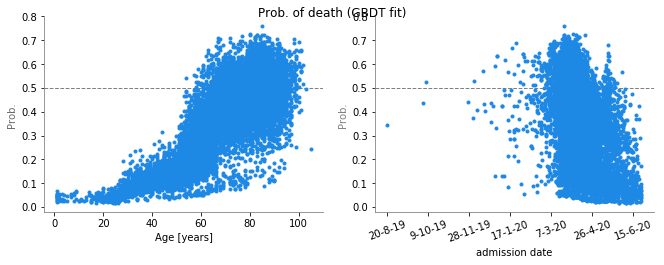

In [130]:
from matplotlib import rc,cm
rc('axes',edgecolor='grey')

fig, ax = plt.subplots(1, 2, figsize=(4 / 3 * 2 * 3.5, 3.5), sharey=False)
ax[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0].plot(X_train['Age (x10 years)'] * 10, clf_death_peak.bst.predict(xgb.DMatrix(X_train), output_margin=False),'.', color='#1E88E5');
ax[0].set_xlabel("Age [years]");
# ax[0].set_title('Fitted prob. of ICU outcome according to GBDT')
ax[0].set_ylabel('Prob.', color='dimgray');
ax[1].set_ylabel('Prob.', color='gray');

ax[1].plot(sc.inverse_transform(X_train['Admission day']),
           clf_death_peak.bst.predict(xgb.DMatrix(X_train), output_margin=False), '.', color='#1E88E5');
ax[1].set_xlabel('admission date');
# ax[1].set_xlim([300,500])
# ax[0].axhline(0)
fig.suptitle('Prob. of death (GBDT fit)');
fig.tight_layout()

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')

ax[1].set_xticklabels([int_to_date(x, min_date) for x in ax[1].get_xticks()]);
for tick in ax[1].get_xticklabels():
    tick.set_rotation(20)

In [131]:
a = clf_death_peak.bst.predict(xgb.DMatrix(X_test), output_margin=False)

[0.655 0.682 0.708]


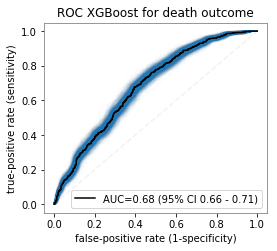

In [132]:
imp.reload(xw)
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
xw.buildROC(y_test, a, ax, color=None, label=None, CI=True)
ax.set_title('ROC XGBoost for death outcome');

In [133]:
import shap
shap_values = shap.TreeExplainer(clf_death_peak.bst).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [134]:
sv = clf_death_peak.bst.predict(xgb.DMatrix(X_train), pred_interactions=True)

In [135]:
shap_interaction_values = shap.TreeExplainer(clf_death_peak.bst).shap_interaction_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


[<matplotlib.lines.Line2D at 0x7f8561d30fd0>]

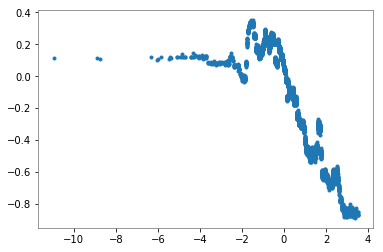

In [136]:
plt.plot(X_train.iloc[:,36], shap_interaction_values[:,36,36], '.')

[-50.0, 0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0]


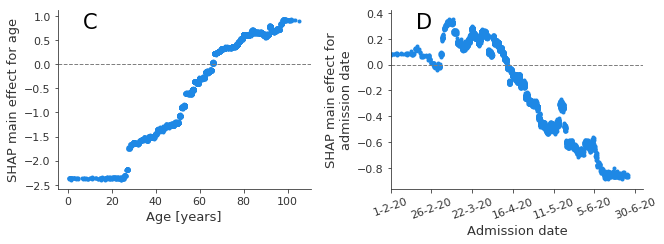

In [137]:
X_train_tmp = X_train.copy()
X_train_tmp['Age (x10 years)'] =  X_train_tmp['Age (x10 years)'] * 10
X_train_tmp['Admission day'] =  sc.inverse_transform(X_train_tmp['Admission day'])
fig, ax = plt.subplots(1, 2, figsize=(4 / 3 * 2 * 3.5, 3.5), sharey=False)
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
# ax[2].axhline(y=0, color='gray', linestyle='--', linewidth=1)
shap.dependence_plot(
    ("Age (x10 years)", "Age (x10 years)"),
    shap_interaction_values,
    X_train_tmp, color='tab:red',
    ax=ax[0], show=False, x_jitter=1, dot_size=1,
    interaction_index='Age (x10 years)'
#     display_features=X_train.columns
)
shap.dependence_plot(
    ("Admission day", "Admission day"),
    shap_interaction_values, 
    X_train_tmp, x_jitter=1, dot_size=1,
    ax=ax[1], show=False, 
    interaction_index='Admission day'
#     display_features=X_train.columns
)
del X_train_tmp
# shap.dependence_plot(
#     "day_from_beginning",
#     shap_values,
#     X_train,
#     ax=ax[2], show=False,
#     interaction_index='age10year'
# #     display_features=X_train.columns
# )
# ax[1].set_xlim([300, 501])
ax[0].set_ylabel('SHAP main effect for age')
ax[1].set_ylabel('SHAP main effect for\nadmission date')
#ax[2].set_ylabel('SHAP main effect for\nadmission date')
#
# ax[2].plot(((X_train.iloc[:,35] + 10)/max(X_train.iloc[:,35] + 10) - 0.55) / 0.3, shap_interaction_values[:,35,35], '.')
#ax[2].plot(X_train.iloc[:,35].rank() / 12000, shap_interaction_values[:,35,35], '.')
# X_train.columns
#
ax[0].set_xlabel('Age [years]')
ax[1].set_xlabel('Admission date')
#ax[2].set_xlabel('clinical experience')
print(list(ax[1].get_xticks()))
ax[1].set_xticks(range(165, 320, 25))
ax[1].set_xlim([165, 320])

ax[1].set_xticklabels([int_to_date(x, min_date) for x in ax[1].get_xticks()]);
# shap.summary_plot(shap_interaction_values, X_train)
#fig.suptitle('Impact to death outcome');
for tick in ax[1].get_xticklabels():
    tick.set_rotation(20)
    
ax[0].text( 0.1, 0.9, 'C', transform=ax[0].transAxes, fontsize=21)
ax[1].text( 0.1, 0.9, 'D', transform=ax[1].transAxes, fontsize=21)
plt.tight_layout()

[-50.0, 0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0]


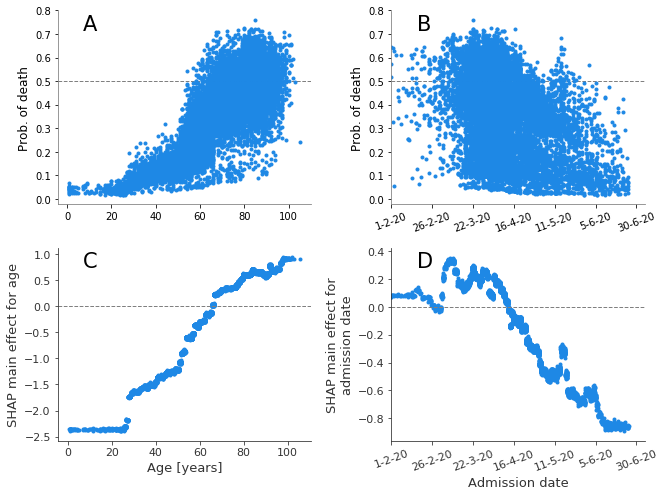

In [138]:
fig, ax = plt.subplots(2, 2, figsize=(4 / 3 * 2 * 3.5, 2* 3.5), sharex=False)

ax[0,0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0,1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0,0].plot(X_train['Age (x10 years)'] * 10, clf_death_peak.bst.predict(xgb.DMatrix(X_train), output_margin=False),'.', color='#1E88E5');
#ax[0,0].set_xlabel("Age [years]");
# ax[0].set_title('Fitted prob. of ICU outcome according to GBDT')
ax[0,0].set_ylabel('Prob. of death', color='black', fontsize=12);
ax[0,1].set_ylabel('Prob. of death', color='black', fontsize=12);

ax[0,1].plot(sc.inverse_transform(X_train['Admission day']),
           clf_death_peak.bst.predict(xgb.DMatrix(X_train), output_margin=False), '.', color='#1E88E5');
# ax[0,1].set_xlabel('admission date');
# ax[1].set_xlim([300,500])
# ax[0].axhline(0)
#fig.suptitle('Prob. of death (GBDT fit)');
fig.tight_layout()

for i in [0,1]:
    ax[0,i].spines['right'].set_visible(False)
    ax[0,i].spines['top'].set_visible(False)
    ax[0,i].yaxis.set_ticks_position('left')
    ax[0,i].xaxis.set_ticks_position('bottom')

ax[0,1].set_xticks(range(165, 320, 25))
ax[0,1].set_xlim([165, 320])
ax[0,1].set_xticklabels([int_to_date(x, min_date) for x in ax[0,1].get_xticks()]);
for tick in ax[0,1].get_xticklabels():
    tick.set_rotation(20)

X_train_tmp = X_train.copy()
X_train_tmp['Age (x10 years)'] =  X_train_tmp['Age (x10 years)'] * 10
X_train_tmp['Admission day'] =  sc.inverse_transform(X_train_tmp['Admission day'])

ax[1,0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[1,1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
# ax[2].axhline(y=0, color='gray', linestyle='--', linewidth=1)

shap.dependence_plot(
    ("Age (x10 years)", "Age (x10 years)"),
    shap_interaction_values,
    X_train_tmp, color='tab:red',
    ax=ax[1,0], show=False, x_jitter=1, dot_size=1,
    interaction_index='Age (x10 years)'
#     display_features=X_train.columns
)
shap.dependence_plot(
    ("Admission day","Admission day"),
    shap_interaction_values, 
    X_train_tmp, x_jitter=1, dot_size=1,
    ax=ax[1,1], show=False, 
    interaction_index='Admission day'
#     display_features=X_train.columns
)
del X_train_tmp
# shap.dependence_plot(
#     "day_from_beginning",
#     shap_values,
#     X_train,
#     ax=ax[2], show=False,
#     interaction_index='age10year'
# #     display_features=X_train.columns
# )
# ax[1].set_xlim([300, 501])
ax[1,0].set_ylabel('SHAP main effect for age')
ax[1,1].set_ylabel('SHAP main effect for\nadmission date')
#ax[2].set_ylabel('SHAP main effect for\nadmission date')
#
# ax[2].plot(((X_train.iloc[:,35] + 10)/max(X_train.iloc[:,35] + 10) - 0.55) / 0.3, shap_interaction_values[:,35,35], '.')
#ax[2].plot(X_train.iloc[:,35].rank() / 12000, shap_interaction_values[:,35,35], '.')
# X_train.columns
#
ax[1,0].set_xlabel('Age [years]')
ax[1,1].set_xlabel('Admission date')
#ax[2].set_xlabel('clinical experience')
print(list(ax[1,1].get_xticks()))
ax[1,1].set_xticks(range(165, 320, 25))
ax[1,1].set_xlim([165, 320])



ax[1,1].set_xticklabels([int_to_date(x, min_date) for x in ax[1,1].get_xticks()]);
# shap.summary_plot(shap_interaction_values, X_train)
#fig.suptitle('Impact to death outcome');
for tick in ax[1,1].get_xticklabels():
    tick.set_rotation(20)
    
ax[0,0].text( 0.1, 0.9, 'A', transform=ax[0,0].transAxes, fontsize=21)
ax[0,1].text( 0.1, 0.9, 'B', transform=ax[0,1].transAxes, fontsize=21)
ax[1,0].text( 0.1, 0.9, 'C', transform=ax[1,0].transAxes, fontsize=21)
ax[1,1].text( 0.1, 0.9, 'D', transform=ax[1,1].transAxes, fontsize=21)
plt.tight_layout()
plt.savefig('results_10Nov/shap_dependence_with_prob_death_peak_1__.png')

In [139]:
def is_not_ethn2(x):
    if x in ['Bangladeshi', 'Black African', 'Black Caribbean', 'Chinese',  'Other ethn.',  'Indian',  'Other Asian',
             'Other black', 'Other mixed', 'Eth. unknown', 'Eth. NA',
             'Other white', 'Pakistani', 'White and Asian', 'White and black African',
             'White and black Caribbean', 'White British', 'White Irish']:
        return 1
    elif ('Sex' in x) or ('Age' in x) or ('Admis' in x) or ('Pregnan' in x) or ("Asympt" in x) or ("Immunosuppression treatment" in x):
        return 0
    else:
        return 2

In [140]:
shap_values_death = shap_values

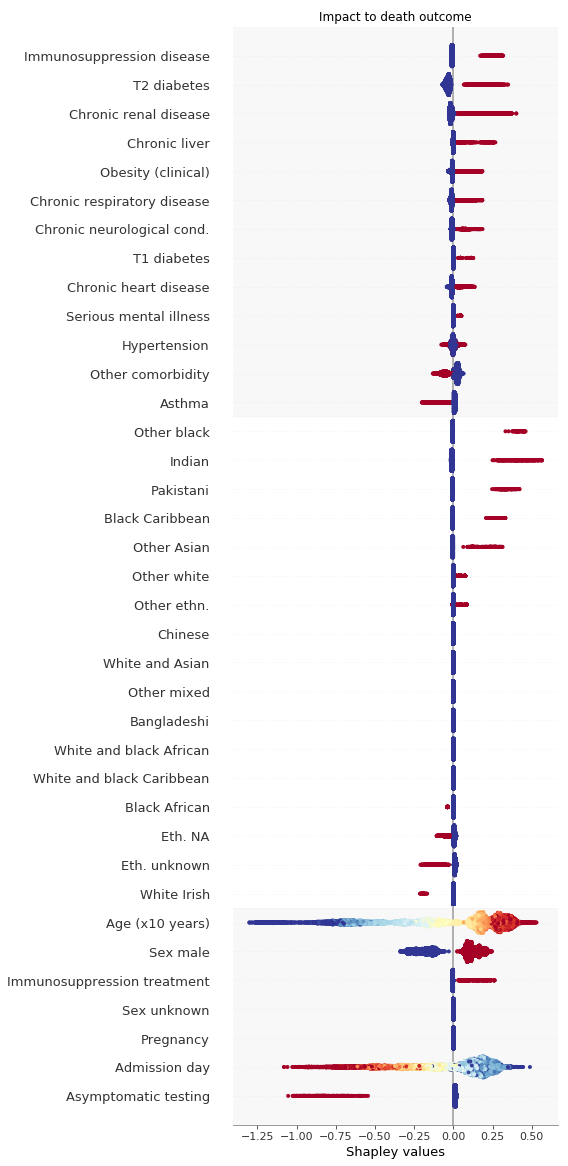

In [141]:
import shap_summary_plot as ssp
# imp.reload(ssp)
sorting = np.array([is_not_ethn2(x) for x in X_train.columns.values])
idx = np.where(X_train.columns == 'Age (x10 years)')[0][0]
shap_values_ = shap_values_death
shap_values_[:,idx] = shap_values_[:,idx] / 2 
ssp.summary_plot(shap_values_, 
                  X_train, max_display=37,  cmap=cm.get_cmap('RdYlBu_r') ,show=False,
                  feature_names=X_train.columns, color_bar=False, sort=True, sorting=sorting)
plt.title('Impact to death outcome')
fig = plt.gcf()
plt.xlabel('Shapley values')
ax = fig.gca()
ax.autoscale(enable=False)
ax.fill_between([-10,100],[-1,-1], [6.5, 6.5], color='grey', alpha=0.05, zorder=-100)
ax.fill_between([-10,100],[23.5, 23.5], [100,105], color='grey', alpha=0.05, zorder=-100)
fig.tight_layout()
fig.savefig('results_10Nov/shap_summary_death_peak_1_.png')

## ICU outcome

In [142]:
target = 'is_ICU'
predictors = [x for x in C.columns if x not in targets]
X_train, X_test, y_train, y_test = train_test_split(C[predictors], C[target], test_size=0.1, random_state=42)

In [143]:
best_params_ICU_peak = fmin(fn=objective,
            algo=tpe.suggest,
            max_evals=500,
            space=space)

100%|██████████| 500/500 [38:45<00:00,  3.89s/it, best loss: -0.8336538723806189]


In [144]:
best_params_ICU_peak

{'gamma': 4.158837994781173,
 'learning_rate': 0.11514453303438271,
 'max_depth': 10.0,
 'min_child_weight': 4.1759692675221,
 'subsample': 0.9345355325458432}

In [145]:
# best_params_ICU_peak = {'gamma': 7.883058915840179,
#  'learning_rate': 0.1274126340844039,
#  'max_depth': 13,
#  'min_child_weight': 1.5972015384036142,
#  'subsample': 0.6253316359620504,
#  'alpha': 0.5,
#  'lambda': 0,
#  'objective': 'binary:logistic'}

In [146]:
best_params_ICU_peak['alpha']= 0.5
best_params_ICU_peak['lambda']= 0
clf_ICU_peak = binary_Classifier(params=best_params_ICU_peak, num_boost_round=200)
# best_params_ICU_peak

{'gamma': 4.158837994781173, 'learning_rate': 0.11514453303438271, 'max_depth': 10.0, 'min_child_weight': 4.1759692675221, 'subsample': 0.9345355325458432, 'alpha': 0.5, 'lambda': 0, 'objective': 'binary:logistic'}


In [147]:
clf_ICU_peak.fit(X_train, y_train)

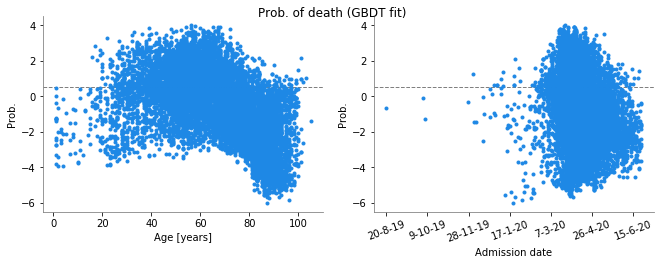

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(4 / 3 * 2 * 3.5, 3.5), sharey=True)
ax[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0].plot(X_train['Age (x10 years)'] * 10, clf_ICU_peak.bst.predict(xgb.DMatrix(X_train), output_margin=True),'.',
           color='#1E88E5');
ax[0].set_xlabel("Age [years]");
# ax[0].set_title('Fitted prob. of ICU outcome according to GBDT')
ax[0].set_ylabel('Prob.');
ax[1].set_ylabel('Prob.');

ax[1].plot(sc.inverse_transform(X_train['Admission day']),
           clf_ICU_peak.bst.predict(xgb.DMatrix(X_train), output_margin=True),'.', color='#1E88E5');
ax[1].set_xlabel('Admission date');
# ax[1].set_xlim([300,500])

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    
fig.suptitle('Prob. of death (GBDT fit)');
fig.tight_layout()
ax[1].set_xticklabels([int_to_date(x, min_date) for x in ax[1].get_xticks()]);
for tick in ax[1].get_xticklabels():
    tick.set_rotation(20)

In [149]:
a = clf_ICU_peak.bst.predict(xgb.DMatrix(X_test), output_margin=True)

[0.807 0.828 0.848]


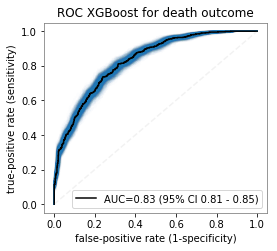

In [150]:
fig, ax = plt.subplots(1,1,figsize=(4, 3.5))
xw.buildROC(y_test, a, ax, color=None, label=None, CI=True)
ax.set_title('ROC XGBoost for death outcome');

In [151]:
shap_values = shap.TreeExplainer(clf_ICU_peak.bst).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [152]:
# import  xgboost as xgb
sv = clf_ICU_peak.bst.predict(xgb.DMatrix(X_train), pred_interactions=True)

In [153]:
shap_interaction_values = shap.TreeExplainer(clf_ICU_peak.bst).shap_interaction_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


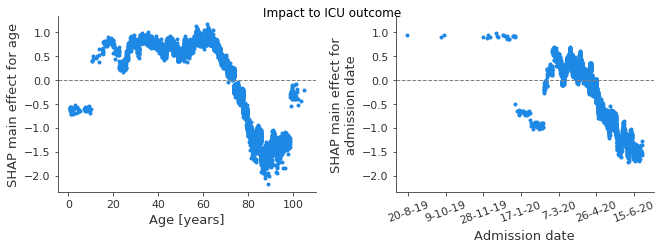

In [154]:
X_train_tmp = X_train.copy()
X_train_tmp['Age (x10 years)'] =  X_train_tmp['Age (x10 years)'] * 10
X_train_tmp['Admission day'] =  sc.inverse_transform(X_train_tmp['Admission day'])
fig, ax = plt.subplots(1, 2, figsize=(4 / 3 * 2 * 3.5, 3.5), sharey=True)
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
shap.dependence_plot(
    ('Age (x10 years)', 'Age (x10 years)'),
    shap_interaction_values,
    X_train_tmp,
    color='tab:red',
    ax=ax[0], show=False, x_jitter=1, dot_size=1,
    interaction_index='Age (x10 years)'
#     display_features=X_train.columns
)
shap.dependence_plot(
    ("Admission day", "Admission day"),
    shap_interaction_values, 
    X_train_tmp, x_jitter=1, dot_size=1,
    ax=ax[1], show=False, 
    interaction_index='Admission day'
#     display_features=X_train.columns
)
del X_train_tmp
# shap.dependence_plot(
#     "day_from_beginning",
#     shap_values,
#     X_train,
#     ax=ax[2], show=False,
#     interaction_index='age10year'
# #     display_features=X_train.columns
# )
# ax[1].set_xlim([300, 501])
ax[0].set_ylabel('SHAP main effect for age')
ax[1].set_ylabel('SHAP main effect for\nadmission date')
ax[0].set_xlabel('Age [years]')
ax[1].set_xlabel('Admission date')
ax[1].set_xticklabels([int_to_date(x, min_date) for x in ax[1].get_xticks()]);

for tick in ax[1].get_xticklabels():
    tick.set_rotation(20)
# shap.summary_plot(shap_interaction_values, X_train)
plt.tight_layout()
fig.suptitle('Impact to ICU outcome');

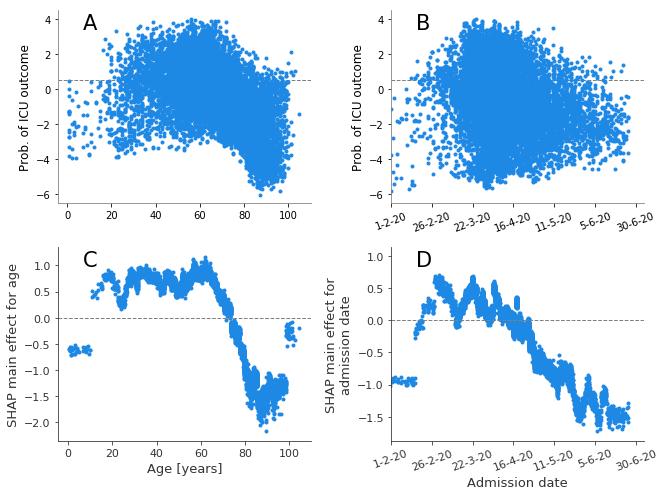

In [155]:
fig, ax = plt.subplots(2, 2, figsize=(4 / 3 * 2 * 3.5, 3.5* 2), sharey=False)
ax[0,0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0,1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
ax[0,0].plot(X_train['Age (x10 years)'] * 10, clf_ICU_peak.bst.predict(xgb.DMatrix(X_train), output_margin=True),'.',
           color='#1E88E5');
# ax[0,0].set_xlabel("Age [years]");
# ax[0].set_title('Fitted prob. of ICU outcome according to GBDT')
ax[0,0].set_ylabel('Prob. of ICU outcome', fontsize=12);
ax[0,1].set_ylabel('Prob. of ICU outcome', fontsize=12);

ax[0,1].plot(sc.inverse_transform(X_train['Admission day']),
           clf_ICU_peak.bst.predict(xgb.DMatrix(X_train), output_margin=True),'.', color='#1E88E5');
# ax[0, 1].set_xlabel('Admission date');
# ax[1].set_xlim([300,500])

for i in [0,1]:
    ax[0,i].spines['right'].set_visible(False)
    ax[0,i].spines['top'].set_visible(False)
    ax[0,i].yaxis.set_ticks_position('left')
    ax[0,i].xaxis.set_ticks_position('bottom')
    
# fig.suptitle('Prob. of death (GBDT fit)');
ax[0,1].set_xticks(range(165, 320, 25))
ax[0,1].set_xlim([165, 320])
ax[0,1].set_xticklabels([int_to_date(x, min_date) for x in ax[0,1].get_xticks()]);
for tick in ax[0,1].get_xticklabels():
    tick.set_rotation(20)

X_train_tmp = X_train.copy()
X_train_tmp['Age (x10 years)'] =  X_train_tmp['Age (x10 years)'] * 10
X_train_tmp['Admission day'] =  sc.inverse_transform(X_train_tmp['Admission day'])


ax[1,0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[1,1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
shap.dependence_plot(
    ('Age (x10 years)', 'Age (x10 years)'),
    shap_interaction_values,
    X_train_tmp,
    color='tab:red',
    ax=ax[1,0], show=False, x_jitter=1, dot_size=1,
    interaction_index='Age (x10 years)'
#     display_features=X_train.columns
)
shap.dependence_plot(
    ("Admission day", "Admission day"),
    shap_interaction_values, 
    X_train_tmp, x_jitter=1, dot_size=1,
    ax=ax[1,1], show=False, 
    interaction_index='Admission day'
#     display_features=X_train.columns
)
del X_train_tmp
# shap.dependence_plot(
#     "day_from_beginning",
#     shap_values,
#     X_train,
#     ax=ax[2], show=False,
#     interaction_index='age10year'
# #     display_features=X_train.columns
# )
# ax[1].set_xlim([300, 501])
ax[1,0].set_ylabel('SHAP main effect for age')
ax[1,1].set_ylabel('SHAP main effect for\nadmission date')
ax[1,0].set_xlabel('Age [years]')
ax[1,1].set_xlabel('Admission date')

ax[1,1].set_xticks(range(165, 320, 25))
ax[1,1].set_xlim([165, 320])
ax[1,1].set_xticklabels([int_to_date(x, min_date) for x in ax[1,1].get_xticks()]);

for tick in ax[1,1].get_xticklabels():
    tick.set_rotation(20)
plt.tight_layout()

ax[0,0].text( 0.1, 0.9, 'A', transform=ax[0,0].transAxes, fontsize=21)
ax[0,1].text( 0.1, 0.9, 'B', transform=ax[0,1].transAxes, fontsize=21)
ax[1,0].text( 0.1, 0.9, 'C', transform=ax[1,0].transAxes, fontsize=21)
ax[1,1].text( 0.1, 0.9, 'D', transform=ax[1,1].transAxes, fontsize=21)
plt.tight_layout()
plt.savefig('results_10Nov/shap_dependence_with_prob_ICU_peak_1__.png')

Summary plot of Shapley values for for death outcome prediction: 

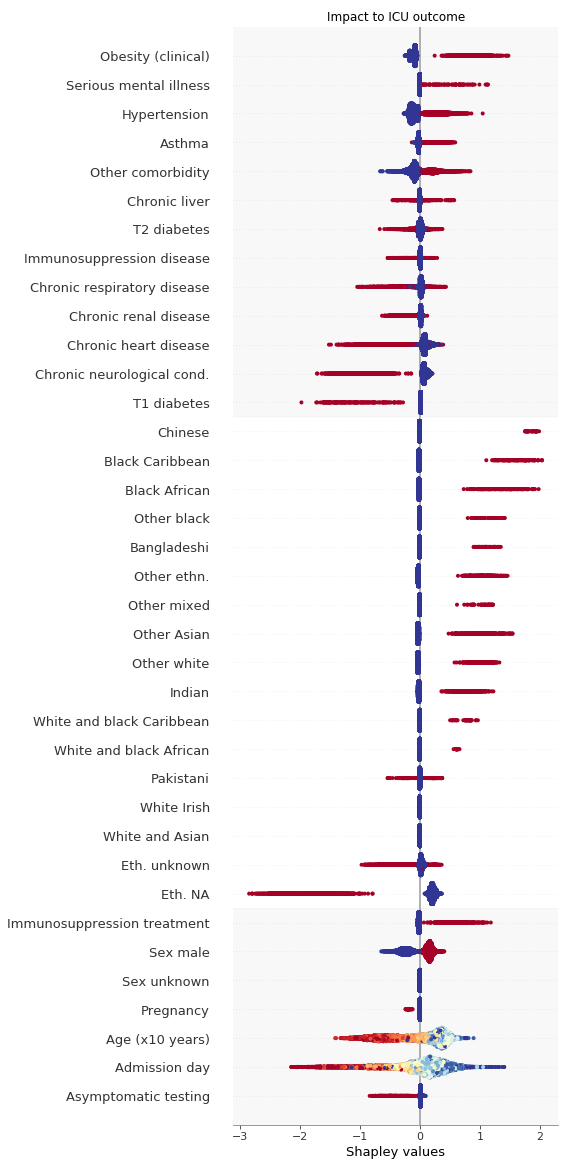

In [156]:
import shap_summary_plot as ssp
# imp.reload(ssp)
sorting = np.array([is_not_ethn2(x) for x in X_train.columns.values])

idx = np.where(X_train.columns == 'Age (x10 years)')[0][0]
shap_values_ = shap_values
shap_values_[:,idx] = shap_values[:,idx] / 2

ssp.summary_plot(shap_values,
                 X_train, max_display=37,
                 cmap=cm.get_cmap('RdYlBu_r'),
                 feature_names=X_train.rename(columns=dizionario).columns,
                 color_bar=False, sort=True, show=False, sorting=sorting)
fig = plt.gcf()
ax = fig.gca()
ax.autoscale(enable=False)
ax.fill_between([-10,100],[-1,-1], [6.5, 6.5], color='grey', alpha=0.05, zorder=-100)
ax.fill_between([-10,100],[23.5,23.5], [100,105], color='grey', alpha=0.05, zorder=-100)

plt.title('Impact to ICU outcome')
plt.tight_layout()
plt.xlabel('Shapley values')
fig.savefig('results_10Nov/shap_summary_ICU_peak_1_.png')

# Cross plot of Shapley values

In [157]:
shap_values_ICU = shap_values

In [158]:
def scale(x):
    m=np.min(x)
    M=np.max(x)
    X = (x - m) / (M-m)
    return X

In [261]:
sorting = np.array([is_not_ethn2(x) for x in X_train.columns.values])
_ = ssp.rank_shap(shap_values_death, X_train.values, sorting)
#_ = np.argsort(sorting)
#idx = np.arange(36)[_]
X_train.columns.values[_[::-1]]

array(['Immunosuppression disease', 'T2 diabetes',
       'Chronic renal disease', 'Chronic liver', 'Obesity (clinical)',
       'Chronic respiratory disease', 'Chronic neurological cond.',
       'T1 diabetes', 'Chronic heart disease', 'Serious mental illness',
       'Hypertension', 'Other comorbidity', 'Asthma', 'Other black',
       'Indian', 'Pakistani', 'Black Caribbean', 'Other Asian',
       'Other white', 'Other ethn.', 'Chinese', 'White and Asian',
       'Other mixed', 'Bangladeshi', 'White and black African',
       'White and black Caribbean', 'Black African', 'Eth. NA',
       'Eth. unknown', 'White Irish', 'Age (x10 years)', 'Sex male',
       'Immunosuppression treatment', 'Sex unknown', 'Pregnancy',
       'Admission day', 'Asymptomatic testing'], dtype=object)

In [160]:
X_train.columns.values[_[::-1]][:13], X_train.columns.values[_[::-1]][13:30], X_train.columns.values[_[::-1]][31:]

(array(['Immunosuppression disease', 'T2 diabetes',
        'Chronic renal disease', 'Chronic liver', 'Obesity (clinical)',
        'Chronic respiratory disease', 'Chronic neurological cond.',
        'T1 diabetes', 'Chronic heart disease', 'Serious mental illness',
        'Hypertension', 'Other comorbidity', 'Asthma'], dtype=object),
 array(['Other black', 'Indian', 'Pakistani', 'Black Caribbean',
        'Other Asian', 'Other white', 'Other ethn.', 'Chinese',
        'White and Asian', 'Other mixed', 'Bangladeshi',
        'White and black African', 'White and black Caribbean',
        'Black African', 'Eth. NA', 'Eth. unknown', 'White Irish'],
       dtype=object),
 array(['Sex male', 'Immunosuppression treatment', 'Sex unknown',
        'Pregnancy', 'Admission day', 'Asymptomatic testing'], dtype=object))

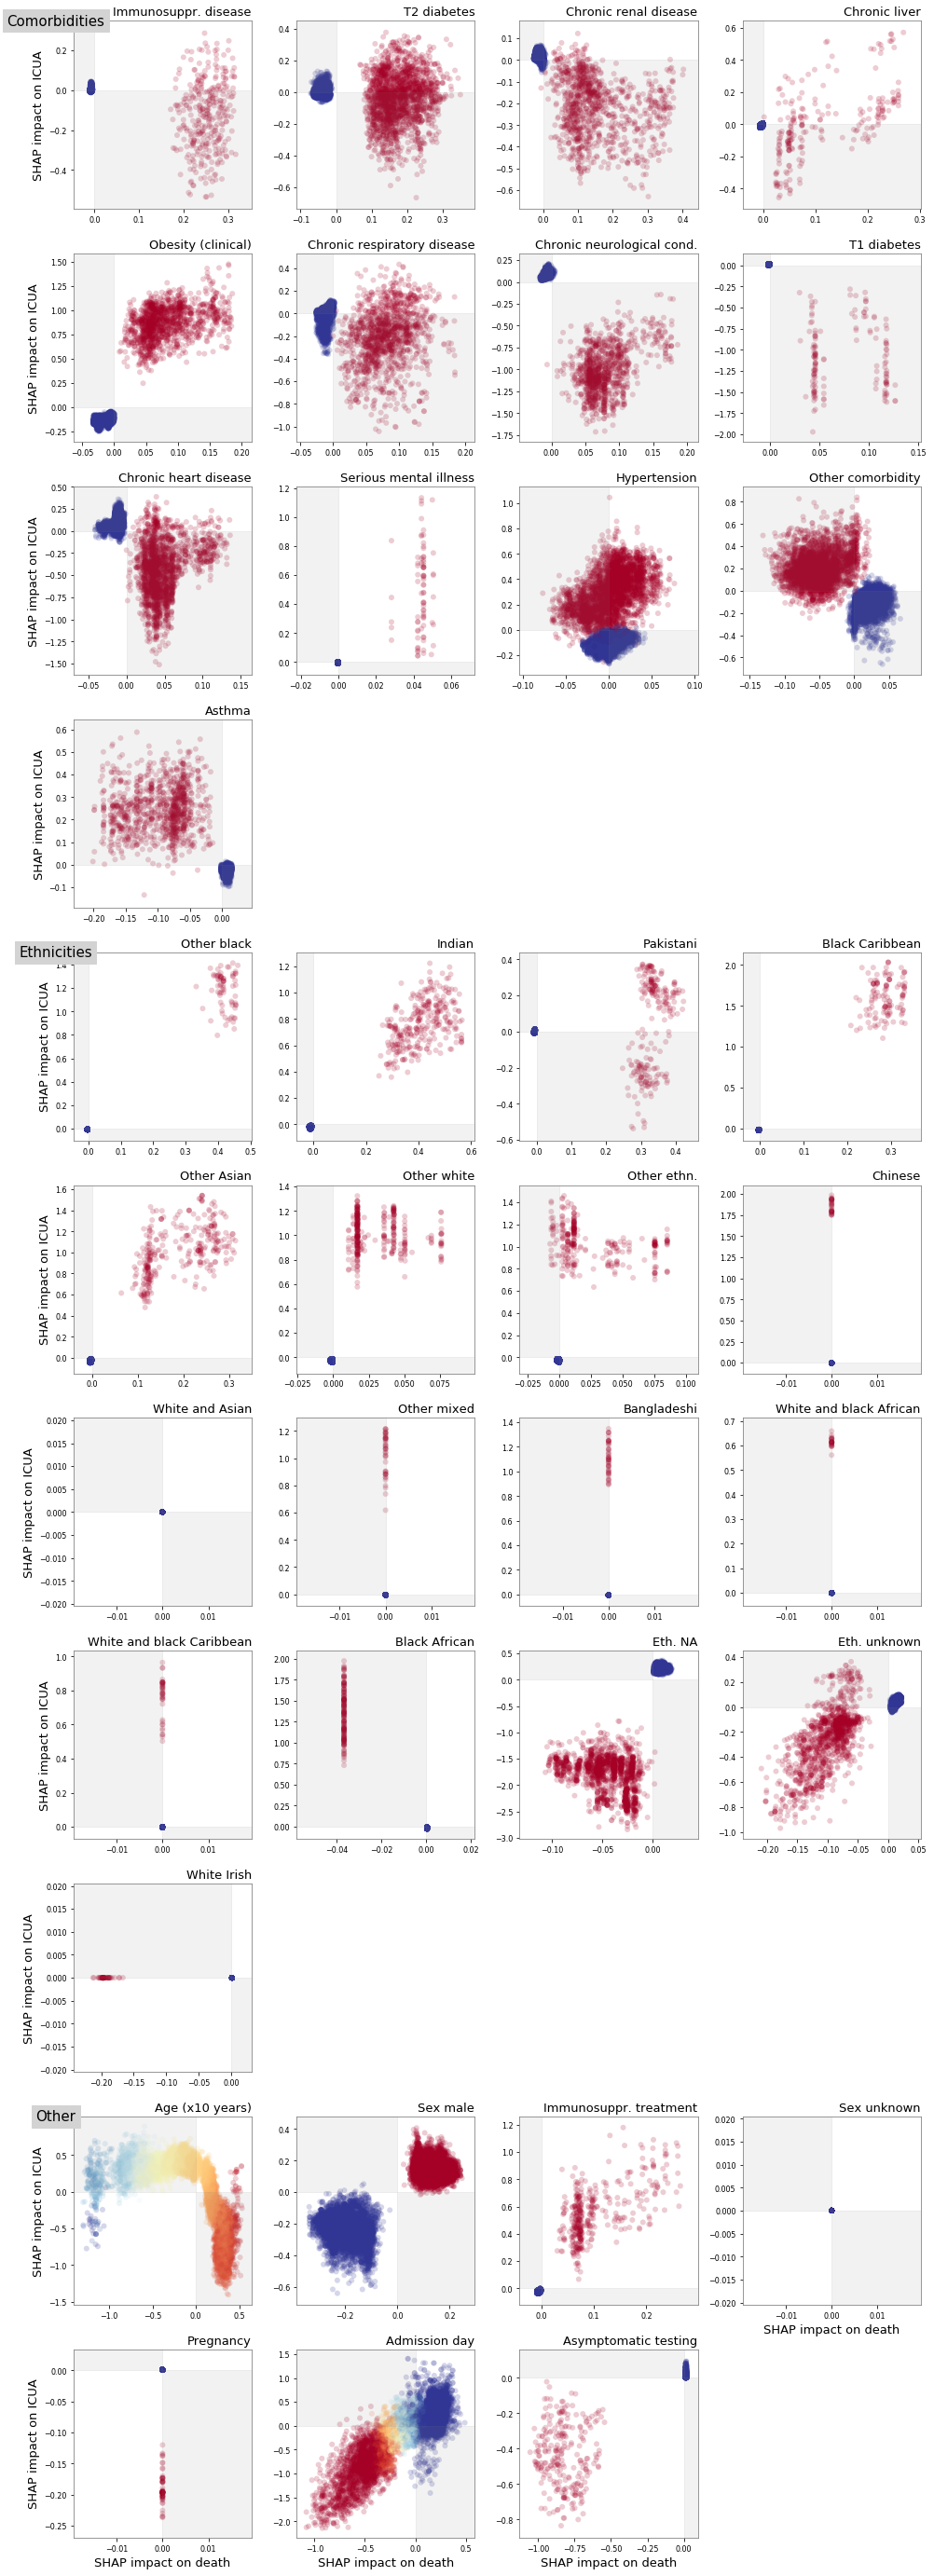

In [264]:
fig, ax = plt.subplots(11, 4, figsize=(4 * 3.5, 11 * 3.5))
cmap=cm.get_cmap('RdYlBu_r')
nomi=X_train.rename(columns=dizionario).rename(columns={'Immunosuppression treatment':'Immunosuppr. treatment', 'Immunosuppression disease': 'Immunosuppr. disease'}).columns.values
for n,i in enumerate(_[::-1][:13]):
    k = n % 4
    j = int(n / 4)
    values = X_train.values[:,i]
    c = cmap(scale(values))
    alpha = 0.2
    ax[j,k].scatter(shap_values_death[:,i], shap_values_ICU[:,i], alpha=alpha, linewidths=0, c=c)
    ax[j,k].autoscale(False)
    ax[j,k].fill_between([0,100],[0,0],[-100,-100], alpha=0.1, color='gray')
    ax[j,k].fill_between([-100,0],[100,100],[0, 0], alpha=0.1, color='gray')
    ax[j,k].set_title(nomi[i], fontdict={'fontsize':13}, loc='right')
    for tick in ax[j, k].xaxis.get_major_ticks() + ax[j, k].yaxis.get_major_ticks():
        tick.label.set_fontsize(8)

for n,i in enumerate(_[::-1][13:30]):
    k = (n + 16) % 4
    j = int((n + 16) / 4)
    values = X_train.values[:,i]
    c = cmap(values)
    alpha = 0.2
    ax[j,k].scatter(shap_values_death[:,i], shap_values_ICU[:,i], alpha=alpha, linewidths=0, c=c)
    ax[j,k].autoscale(False)
    ax[j,k].fill_between([0,100],[0,0],[-100,-100], alpha=0.1, color='gray')
    ax[j,k].fill_between([-100,0],[100,100],[0, 0], alpha=0.1, color='gray')
    ax[j,k].set_title(nomi[i], fontdict={'fontsize':13}, loc='right')
    for tick in ax[j, k].xaxis.get_major_ticks() + ax[j, k].yaxis.get_major_ticks():
        tick.label.set_fontsize(8)      
        
for n,i in enumerate(_[::-1][30:]):
    k = (n+36) % 4
    j = int((n +36)/ 4)
    values = X_train.values[:,i]
    if (n == 0) or (n == 6):
        c = cmap(scale(values))
    else:
        c = cmap(values)
    alpha = 0.2
    ax[j,k].scatter(shap_values_death[:,i], shap_values_ICU[:,i], alpha=alpha, linewidths=0, c=c)
    ax[j,k].autoscale(False)
    ax[j,k].fill_between([0,100],[0,0],[-100,-100], alpha=0.1, color='gray')
    ax[j,k].fill_between([-100,0],[100,100],[0, 0], alpha=0.1, color='gray')
    ax[j,k].set_title(nomi[i],fontdict={'fontsize':13}, loc='right')

    for tick in ax[j, k].xaxis.get_major_ticks() + ax[j, k].yaxis.get_major_ticks():
        tick.label.set_fontsize(8)
        
ax[3,3].set_axis_off()
ax[3,2].set_axis_off()
ax[3,1].set_axis_off()
ax[8,3].set_axis_off()
ax[8,2].set_axis_off()
ax[8,1].set_axis_off()
ax[10,3].set_axis_off()


for x in range(11): 
    ax[x,0].set_ylabel('SHAP impact on ICUA', fontsize=13)
    
for x in range(4): 
    ax[10,x].set_xlabel('SHAP impact on death', fontsize=13)


    
ax[9,3].set_xlabel('SHAP impact on death', fontsize=13)


bbox=dict(boxstyle="square", ec='#d3d3d3', fc='#d3d3d3')
ax[0,0].text(-0.1,1,'Comorbidities',  horizontalalignment='center', bbox=bbox,
             verticalalignment='center', transform=ax[0,0].transAxes, fontsize=15)
ax[4,0].text(-0.1,1,'Ethnicities',  horizontalalignment='center', bbox=bbox,
             verticalalignment='center', transform=ax[4,0].transAxes, fontsize=15)
ax[9,0].text(-0.1,1,'Other',  horizontalalignment='center', bbox=bbox,
             verticalalignment='center', transform=ax[9,0].transAxes, fontsize=15)

plt.tight_layout()

# ax[2,0].text(-0.15, 0.5, 'SHAP impact on ICUA', fontsize=17, rotation=90, horizontalalignment='right', 
#              verticalalignment='center',transform=ax[2,0].transAxes);
# ax[10,1].text(0.5, -0.1, 'SHAP impact on death', fontsize=17, horizontalalignment='center', 
#              verticalalignment='top', transform=ax[10,1].transAxes);
fig.savefig('results_10Nov/shap_death_vs_ICU.png', dpi=400, bbox_inches='tight')

# Rank test

In [162]:
rank_death_ = ssp.rank_shap(shap_values_death, X_train.values, None)
#_ = np.argsort(sorting)
#idx = np.arange(36)[_]
shap_death = pd.DataFrame({'Row.names':X_train.columns.values[rank_death_][::-1],
                           'rank.shap':range(37)}).sort_values(by='rank.shap')

In [163]:
shap_death.head()

,Row.names,rank.shap
0,Other black,0
1,Indian,1
2,Pakistani,2
3,Black Caribbean,3
4,Age (x10 years),4


In [164]:
rank_ICU_ = ssp.rank_shap(shap_values_ICU, X_train.values, None)
#_ = np.argsort(sorting)
#idx = np.arange(36)[_]
shap_ICU  = pd.DataFrame({'Row.names':X_train.columns.values[rank_ICU_][::-1],
                          'rank.shap':range(37)}).sort_values(by='rank.shap')

In [165]:
shap_ICU.head()

,Row.names,rank.shap
0,Chinese,0
1,Black Caribbean,1
2,Black African,2
3,Other black,3
4,Bangladeshi,4


In [166]:
log_ICU = logistic_summary_ICU.sort_values(by='OR.x', ascending=False)[['Row.names', 'OR.x', '15.9 %', '84.1 %', 'p.x']].reset_index().drop(columns='index')
log_ICU = log_ICU.reset_index().rename(columns={'index': 'rank.OR'})

In [167]:
log_death = logistic_summary_death.sort_values(by='OR.x', ascending=False)[['Row.names', 'OR.x', '15.9 %', '84.1 %', 'p.x']].reset_index().drop(columns='index')
log_death = log_death.reset_index().rename(columns={'index': 'rank.OR'})

In [168]:
f_rank_death = pd.merge(left=shap_death, right=log_death , on='Row.names')
f_rank_ICU= pd.merge(left=shap_ICU, right=log_ICU , on='Row.names')

In [169]:
f_rank_ICU.head()

,Row.names,rank.shap,rank.OR,OR.x,15.9 %,84.1 %,p.x
0,Chinese,0,0,10.224427,6.118429,18.319914,1.968065e-05
1,Black Caribbean,1,1,5.246864,4.094292,6.802145,6.251541e-11
2,Black African,2,2,4.170273,3.377820,5.189660,2.832579e-11
3,Other black,3,4,3.582559,2.615911,4.998075,7.846534e-05
4,Bangladeshi,4,8,3.085921,2.193977,4.406858,1.207336e-03


In [170]:
f_rank_death.head()

,Row.names,rank.shap,rank.OR,OR.x,15.9 %,84.1 %,p.x
0,Other black,0,1,2.204357,1.709782,2.836647,1.779209e-03
1,Indian,1,5,1.838289,1.614361,2.091995,2.622982e-06
2,Pakistani,2,7,1.708806,1.472895,1.980471,2.953867e-04
3,Black Caribbean,3,11,1.498998,1.230465,1.823896,3.961707e-02
4,Age (x10 years),4,9,1.560188,1.536631,1.584249,9.584778e-187


In [171]:
from scipy.stats import kendalltau, spearmanr

In [172]:
tau, p_value = spearmanr(f_rank_death['rank.shap'], f_rank_death['rank.OR'])
print(tau, p_value)

0.5132764343290659 0.0011590746505837368


In [173]:
tau, p_value = spearmanr(f_rank_ICU['rank.shap'], f_rank_ICU['rank.OR'])
print(tau, p_value)

0.9428639165481268 2.783402245287226e-18


In [174]:
tau, p_value = kendalltau(f_rank_death['rank.shap'], f_rank_death['rank.OR'])
print(tau, p_value)

0.4594594594594595 6.277276081670381e-05


In [175]:
tau, p_value = kendalltau(f_rank_ICU['rank.shap'], f_rank_ICU['rank.OR'])
print(tau, p_value)

0.8348348348348349 3.545763829995434e-13


In [176]:
imp.reload(ssp)
_,I_ICU, sd_I_ICU = ssp.rank_shap(shap_values_ICU, X_train.values, None, False)
___ICU  = pd.DataFrame({'name':X_train.columns.values, 'I_icu':I_ICU, 'sd_I_ICU':  sd_I_ICU })
___ICU['rank2'] = ___ICU['I_icu'].rank(ascending=False)
# plt.plot(___['rank2'], ___['rank'], '.')
___ICU.sort_values(by='I_icu').head()

,name,I_icu,sd_I_ICU,rank2
31,Eth. NA,-1.782405,0.328605,37.0
35,T1 diabetes,-1.089436,0.383877,36.0
7,Chronic neurological cond.,-1.012528,0.259174,35.0
3,Chronic heart disease,-0.446696,0.307211,34.0
0,Asymptomatic testing,-0.439540,0.174622,33.0


In [177]:
_,I_death, sd_I_death = ssp.rank_shap(shap_values_death, X_train.values, None, False)
___death  = pd.DataFrame({'name':X_train.columns.values, 'I_death':I_death, 'sd_I_death':sd_I_death})
___death['rank2'] = ___death['I_death'].rank(ascending=False)
# plt.plot(___['rank2'], ___['rank'], '.')
___death.sort_values(by='rank2').head()

,name,I_death,sd_I_death,rank2
18,Other black,0.419921,0.025721,1.0
20,Indian,0.411721,0.078489,2.0
19,Pakistani,0.332270,0.034396,3.0
30,Black Caribbean,0.285321,0.029097,4.0
14,Age (x10 years),0.257689,0.086052,5.0


In [178]:
# ___death.merge(___ICU, on='name').to_csv('I_scores2.csv')

In [179]:
___ICU_new = f_rank_ICU.merge(___ICU, left_on='Row.names', right_on='name')
___death_new = f_rank_death.merge(___death, left_on='Row.names', right_on='name')

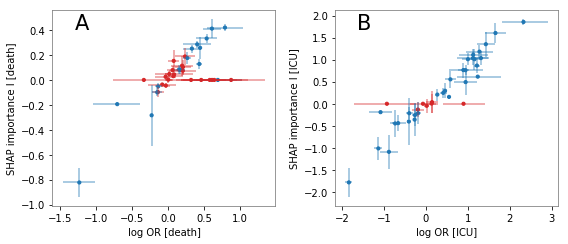

In [180]:
col=['tab:red' if ___death_new.loc[i,'p.x'] > 0.05 else 'tab:blue' for i in range(0,37)]
fig, ax = plt.subplots(1, 2 ,figsize=(2 * 4, 3.5))
ax[0].errorbar(np.log(___death_new['OR.x']), ___death_new['I_death'],
               xerr = [
                     np.log(___death_new['OR.x']) - np.log(___death_new['15.9 %']),
                     np.log(___death_new['84.1 %']) - np.log(___death_new['OR.x'])
                    ],
               yerr = ___death_new['sd_I_death'].values,
               fmt='.', markersize=0, alpha=0.5, c=col)
ax[0].scatter(np.log(___death_new['OR.x']), ___death_new['I_death'], c=col,  s=10)
ax[0].set_xlabel('log OR [death]')
ax[0].set_ylabel('SHAP importance I [death]')

col=['tab:red' if ___ICU_new.loc[i,'p.x'] > 0.05 else 'tab:blue' for i in range(0,37)]

ax[1].errorbar(np.log(___ICU_new['OR.x']), ___ICU_new['I_icu'],
                xerr = [
                     np.log(___ICU_new['OR.x']) - np.log(___ICU_new['15.9 %']),
                     np.log(___ICU_new['84.1 %']) - np.log(___ICU_new['OR.x'])
                    ],
               yerr = ___ICU_new['sd_I_ICU'].values,               
               fmt='.', markersize=0, alpha=0.5, c=col)
ax[1].scatter(np.log(___ICU_new['OR.x']), ___ICU_new['I_icu'], c=col, s=10)
ax[1].set_xlabel('log OR [ICU]')
ax[1].set_ylabel('SHAP importance I [ICU]')
plt.tight_layout()
ax[0].text(0.1, 0.9, 'A', transform=ax[0].transAxes, fontsize=21)
ax[1].text(0.1, 0.9, 'B', transform=ax[1].transAxes, fontsize=21)
plt.savefig('results_10Nov/SHAP_importance.png',  dpi=200)

In [181]:
print(1)

1


# Coefficient table

In [211]:
coefficients_final = logistic_summary_death[['Row.names', 'OR.x', '2.5 %.y', '97.5 %.y', 'p.x']].merge(logistic_summary_ICU[['Row.names', 'OR.x', '2.5 %.y', '97.5 %.y', 'p.x']],
                                                                                                     left_on='Row.names', right_on='Row.names',
                                                                                                     suffixes=('_death', '_ICU'))

In [212]:
coefficients_final.head()

,Row.names,OR.x_death,2.5 %.y_death,97.5 %.y_death,p.x_death,OR.x_ICU,2.5 %.y_ICU,97.5 %.y_ICU,p.x_ICU
0,Immunosuppression disease,1.392103,1.096929,1.764122,0.006309,0.826131,0.632907,1.074423,0.156849
1,T2 diabetes,1.307081,1.168038,1.462326,0.000003,1.018239,0.897919,1.154439,0.777949
2,T1 diabetes,1.227757,0.845259,1.769186,0.275249,0.414272,0.268610,0.627065,0.000044
3,Chronic liver,1.214570,0.893629,1.640559,0.209125,1.145589,0.831353,1.579177,0.405870
4,Chronic respiratory disease,1.187643,1.046686,1.347020,0.007525,0.829764,0.718637,0.957222,0.010704


In [213]:
coefficients_final = coefficients_final.merge(___death_new[['Row.names','I_death']], left_on='Row.names', right_on='Row.names')
coefficients_final = coefficients_final.merge(___ICU_new[['Row.names', 'I_icu']], left_on='Row.names', right_on='Row.names')
#coefficients_final.head()

In [215]:
coefficients_final.to_excel('results_10Nov/final_coeff_table.xls')